**<h1 align="center"> Jabodetabek Property Analysis</h1>**
**<h3 align="center"> by Yasmin Naila Rachmat</h3>**

# Introduction

**Dataset**: Scraping dari Rumah123.com <br>
**Dashboard**: [Jabodetabek Property Analysis](https://public.tableau.com/views/JabodetabekPropertyAnalysis/DESCRIPTIVE?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

**Objective** <br>
Notebook ini digunakan untuk menganalisis harga dan fitur-fotur rumah yang dijual di Jabodetabek berdasarkan data yang di-scraping dari laman [Rumah123.com](https://www.rumah123.com/?utm_source=Google&utm_medium=cpc&utm_campaign=SEM+V1+-+Secondary+Regular+-+Brand+Keyword&gclsrc=aw.ds&&gclid=Cj0KCQiAyoi8BhDvARIsAO_CDsAdcBqzie1ZKwLvUpED9sRFa9NHZXL5bEbuwUbzm7pkpQRf4kzFagMaAjFeEALw_wcB&gad_source=1)

**Problem Statement** <br>
Tujuan penelitian ini adalah untuk melakukan analisis mendalam terhadap data properti di wilayah Jabodetabek dalam waktu dua minggu, dengan tujuan membangun sebuah dashboard interaktif yang dapat memberikan insights yang relevan bagi berbagai stakeholders. Analisis ini akan mencakup pengukuran distribusi harga, korelasi antara fitur-fitur rumah dengan harga, serta tren harga di berbagai wilayah. Selain itu, akan dilakukan perbandingan harga properti berdasarkan fasilitas, tipe, dan kondisi furnitur. Hasil analisis ini diharapkan dapat membantu agen properti menentukan harga jual yang kompetitif, pembeli properti memilih properti yang sesuai, dan pengembang properti merencanakan proyek baru berdasarkan tren pasar yang ada.

**Problem Breakdown** <br>
Analisis ini didasari dengan pertanyaan-pertanyaan berikut:
1. Bagaimana distribusi harga rumah yang dijual di daerah Jabodetabek?
2. Bagimana korelasi antara fitur-fitur rumah dengan harga, luas tanah, dan luas bangunan?
3. Berapa kecenderungan harga jual rumah di tiap kota?
4. Bagaimana hubungan luas tanah dan kota dengan harga properti?
5. Bagaimana hubungan luas bangunan dan kota dengan harga properti?
5. Apa fasilitas yang umum ditemui di pasar properti jabodetabek?
6. Berapa kecenderungan harga jual rumah berdasarkan tipe propertinya?
7. Apa perbandingan properti fully furnished dengan unfurnished?

## Libraries

In [70]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Stats
from scipy.stats import spearmanr, kendalltau
from scipy.stats import iqr

# Imputer
from sklearn.impute import KNNImputer

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [71]:
def simple_cleaning(df):
    """
    Performs basic data cleaning on a Pandas DataFrame:
    1. Strips whitespace from column names.
    2. Strips whitespace from string column values, handling non-string entries safely.
    3. Drops duplicate rows.
    
    Args:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """

    # Strips whitespace from column names
    df.columns = df.columns.str.strip()

    # Strip whitespace from string column values safely, ignoring NaN
    string_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in string_columns:
        # Apply strip only to non-NaN values
        df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # Drop duplicate rows
    df = df.drop_duplicates()

    return df

def check_missing_values(df):
    """
    Function to check missing values in a dataframe.
    
    Args:
    df (pd.DataFrame): The dataframe to check.
    
    Returns:
    pd.DataFrame: A dataframe showing missing counts and percentages.
    """
    missing_values_df = pd.DataFrame({
        'missing_count': df.isna().sum(),
        'missing_percentage': (df.isna().sum() / len(df)) * 100
    }).sort_values(by='missing_percentage', ascending=False)
    
    total_missing_percentage = round((df.isna().sum().sum() / (len(df) * len(df.columns))) * 100, 2)
    
    print(f"\nTotal missing values across all columns: {total_missing_percentage}%")
    return missing_values_df[missing_values_df['missing_count'] > 0]

def check_categorical_cardinality(df):
    """
    Function to check the cardinality (number of unique values) only for categorical columns in a dataframe.
    
    Args:
    df (pd.DataFrame): The dataframe to check.
    
    Returns:
    pd.DataFrame: A dataframe showing the number of unique values in each categorical column.
    """
    # Filter categorical columns (object type)
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Create a dataframe with cardinality info for categorical columns
    cardinality_df = pd.DataFrame({
        'column': categorical_columns,
        'unique_values_count': [df[col].nunique() for col in categorical_columns]
    }).sort_values(by='unique_values_count', ascending=False)
    
    return cardinality_df

def check_outlier(df, cols):
    """
    Function to check the lower and upper bounds of data, as well as the percentage of outliers. 
    This function is only applicable to numeric columns. Ensure that the `cols` parameter contains 
    only numeric columns. Missing values are ignored in the calculations.

    Args:
    data (pd.DataFrame): The dataframe containing the data to check for outliers.
    cols (list): List of column names in the dataframe to check for outliers, which should be numeric columns.

    Returns:
    pd.DataFrame: A dataframe containing the analysis of each column, including the skewness, 
                  distribution category, lower boundary, upper boundary, number of outliers, 
                  and the percentage of outliers.
    """
    
    skewness = [df[col].dropna().skew() for col in cols]  # Mengabaikan nilai NaN saat menghitung skewness

    listItem = []  # List untuk menyimpan setiap row hasil per kolom

    for id, col in enumerate(cols):
        # Mengabaikan nilai NaN pada kolom yang sedang dianalisis
        col_data = df[col].dropna()

        if skewness[id] > 1 or skewness[id] < -1:
            category = 'Highly Skewed'
            IQR = iqr(col_data)
            lower_boundary = col_data.quantile(0.25) - 3 * IQR
            upper_boundary = col_data.quantile(0.75) + 3 * IQR
        elif skewness[id] > 0.5 or skewness[id] < -0.5:
            category = 'Moderately Skewed'
            IQR = iqr(col_data)
            lower_boundary = col_data.quantile(0.25) - 1.5 * IQR
            upper_boundary = col_data.quantile(0.75) + 1.5 * IQR
        else:
            category = 'Normal'
            lower_boundary = col_data.mean() - 3 * col_data.std()
            upper_boundary = col_data.mean() + 3 * col_data.std()

        # Menghitung outlier pada data yang telah di-drop NaN-nya
        outlier = col_data[(col_data > upper_boundary) | (col_data < lower_boundary)]
        outlier_num = len(outlier)
        outlier_percent = outlier_num / len(col_data) * 100  # Menggunakan panjang kolom tanpa NaN

        # Append hasil analisis ke listItem sebagai satu row
        listItem.append([
            col,                      # Nama Kolom
            round(skewness[id], 2),    # Skewness
            category,                  # Kategori Distribusi
            round(lower_boundary, 2),  # Lower Boundary
            round(upper_boundary, 2),  # Upper Boundary
            outlier_num,               # Jumlah Outlier
            round(outlier_percent, 2)  # Persentase Outlier
        ])

    # Membuat DataFrame dari listItem
    df_distribution = pd.DataFrame(listItem, columns=[
        'Column', 'Skewness', 'Distribution', 'LowerBoundary', 'UpperBoundary', 'Jumlah Outlier', 'Percent Outlier (%)'
    ])

    return df_distribution

# Data Loading

In [72]:
# Load data
df =  pd.read_csv("property_jabodetabek.csv")

# Show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Show df
df

,url,title,description,price,location,land_size,building_size,bedroom,bathroom,garage,carport,property_type,certificate,voltage_watt,maid_bedroom,maid_bathroom,kitchen,dining_room,living_room,furniture,building_material,floor_material,floor_level,house_facing,concept_and_style,view,internet_access,road_width,year_built,year_renovated,water_source,corner_property,property_condition,ad_type,ad_id
0,/properti/tangerang/hos16543378/,"Rumah 2 Lantai Bagus Semi Furnished Sertifikat Hak Milik di Daan Mogot, Tangerang",Dijual Termurah Rumah Budi Indah Daan Mogot Siap Huni Rapi 3.65 X 15 Lt. 57 M² Lb. 114 M² 2 Lantai 3+1 Kamar Tidur 2 Kamar Mandi 2200 Watt Pam •Ada Bak Penampungan + Torent Dengan Kapasitas 1100L Garasi 1 Mobil Shm -Terletak Didalam Komplek -Full Renovasi -Area Sangat Strategis -Bebas Banjir -Row Jalan 2 Mobil -Asri Nyaman Dan Tenang -Security 24 Jam -One Gate System -Dekat Sekolah Dan Rumah Sakit Terdekat *Harga : 850Jt Nego (Termurah) ‼️ Property Consultant: Aling.Ng 0856 711 0xxx •Terima Titip Property Jual -Beli -Sewa : Rumah-Ruko-Apartemen-Soho- Gudang-Pabrik-Kavling-Office Space-Gedung-Hotel-Villa-Citra Garden - Pik1-Pluit-Muara Karang-Pik2-Golf Island-Bsd-Tangerang- Gading Serpong-Alam Sutera- Lippo Karawaci-Jabodetabek,8.500000e+08,"Daan Mogot, Tangerang",57 m²,114 m²,3.0,2.0,1.0,1.0,Rumah,SHM - Sertifikat Hak Milik,2200.0,1.0,0.0,0.0,0.0,0.0,Semi Furnished,NaN,NaN,2.0,NaN,NaN,NaN,NaN,Row Jalan 2 Mobil,NaN,NaN,Pam,False,Full Renovasi,NaN,NaN
1,/properti/jakarta-selatan/hos18392523/,Rumah Asri Dan Eklusive Dikawasan Pemukiman Pondok Pinang Selangkah Ke Pondok Indah Dan Mrt Lebak Bulus Dan Tol Tb Simatupang,"Dijual Rumah Asri dan Nyaman di lingkungan yang Tenang ,di Kawasan Pemukiman kebayoran lama dekat ke Pondok Indah dan Lebakbulus . Bangunan Rumah sangat kokoh , Kekar dan terawat juga Halaman depan dan belakang tertata dengan baik . .Desain bangunan sangat Moderen dan Eklusive terdiri dari 2 lantai. Jalan depan Rumah 2 Mobil . Bangunan sekitarnya sangat tertata dengan baik dan teratur . Lokasi sangat strategis sekali karena : - Dekat ke Mall Pondok Indah , Gandaria City dan Cilandak Mall - Dekat ke RS Fatmawaty , RS Siloam , RS Pondok Indah dan RS Mayapada - Dekat ke Stasiun MRT Lebak Bulus dan Stasiun Kereta Kebayoran lama - Dekat ke Tol TB Simatupang dan Tol Lingkar Luar JABODETABEK - Dekat ke Kampus BINUS dan Kampus Prasetiya Mulya -Lokasi sangat strategis sekali sangat cocok buat tempat tinggal, Kos2an Eklusive dan Kantor karena dekat dari jl. Raya Ciputat Kebayoran lama. Rumah dijual cepat untuk info hub : Pesta LR RW Kebayoran Blok M .",4.950000e+09,"Kebayoran Lama, Jakarta Selatan",320 m²,450 m²,5.0,3.0,0.0,2.0,Rumah,SHM - Sertifikat Hak Milik,4400.0,0.0,0.0,0.0,0.0,0.0,Unfurnished,NaN,NaN,2.0,NaN,Moderen dan Eklusive,NaN,NaN,2 Mobil,NaN,NaN,NaN,NaN,terawat,Dijual Cepat,NaN
2,/properti/depok/hos18570241/,Rumah Di Perum Lereng Indah Cinere Perbatasan Pondok Cabe Ciputat,"Dijual Cepat Rumah Di Perum Lereng Indah, Pondok Cabe, Cinere Posisi rumah terletak di perbatasan Pondok Cabe , Pamulang , Ciputat ( Tangerang Selatan) dan Cinere ( Depok ) LT : 78m2 (6*13) LB : +/- 36m2 KT : 2 KM : 1 Bangunan 1 lantai Listrik : 1200 watt Hadap : Timur Carport : 1mobil Row : 1mobil Air tanah SHM Harga Jual : 590 jt (Nego)",5.900000e+08,"Cinere, Depok",78 m²,36 m²,2.0,1.0,0.0,1.0,Rumah,SHM - Sertifikat Hak Milik,1200.0,0.0,0.0,0.0,0.0,0.0,Unfurnished,NaN,NaN,1.0,East,NaN,NaN,NaN,1mobil,NaN,NaN,Air tanah,False,NaN,Dijual Cepat,NaN
3,/properti/jakarta-utara/hos16808954/,DIJUAL TERMURAH RUMAH PIK1 Layar Permai 2 Lantai Shm Sudah Renovasi Rumah Unfurnished Bagus SHM - Sertifikat Hak Milik di Pantai Indah Kapuk,DIJUAL TERMURAH RUMAH PIK1 Layar Permai 4x12 2 Lantai 2+1 Kamar tidur 2 Kamar mandi SHM •Sudah Renovasi | Rapi Terawat •Berada didalam Komplek Asri Bersih Nyaman dan Aman •Lingkungan sangat Asri Sejuk banyak Pohon Rindang •Row Jalan 2 Mobil •Security 24 jam | 1 Gate System •Area sangat strategis Dekat Mall | Sekolah | T

Data telah berhasil dimuat.

# Data Overview

In [73]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398 entries, 0 to 1397
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 1398 non-null   object 
 1   title               1396 non-null   object 
 2   description         1396 non-null   object 
 3   price               1396 non-null   float64
 4   location            1398 non-null   object 
 5   land_size           1296 non-null   object 
 6   building_size       1276 non-null   object 
 7   bedroom             1224 non-null   float64
 8   bathroom            1394 non-null   float64
 9   garage              1330 non-null   float64
 10  carport             1392 non-null   float64
 11  property_type       1046 non-null   object 
 12  certificate         1395 non-null   object 
 13  voltage_watt        909 non-null    float64
 14  maid_bedroom        1393 non-null   float64
 15  maid_bathroom       1380 non-null   float64
 16  kitche

Dataset memiliki 1398 baris dan 35 kolom dengan pembagian berdasarkan tipe data: <br>

- Kategorik: 'url', 'title', 'description', 'location', 'land_size', 'building_size', 'property_type', 'certificate', 'furniture', 'building_material', 'floor_material', 'house_facing', 'concept_and_style', 'view', 'internet_access', 'road_width', 'water_source', 'corner_property', 'property_condition', 'ad_type', 'ad_id' <br>

- Numerik: 'price', 'bedroom', 'bathroom', 'garage', 'carport', 'voltage_watt', 'maid_bedroom', 'maid_bathroom', 'kitchen', 'dining_room', 'living_room', 'floor_level', 'year_built', 'year_renovated'

In [74]:
# Cek cardinality
check_categorical_cardinality(df)

,column,unique_values_count
0,url,1396
1,title,1345
2,description,1339
20,ad_id,567
4,land_size,417
5,building_size,339
3,location,301
15,road_width,145
18,property_condition,126
16,water_source,120


**Hasil dari pengecekan kardinalitas kolom kategorikal di atas antara lain:**
- Kolom `url`, `title`, `description`, dan `ad_id` memiliki nilai kardinalitas yang tinggi sesuai dengan yang sudah diperkirakan. Tingginya kardinalitas tersebut normal ditemui karena kolom-kolom tersebut merupakan kolom unique yang menjadi pembeda dari tiap kolomnya.
- Kolom `land_size`, `building_size`, dan `road_width` perlu ditangani terlebih dahulu agar dapat diubah menjadi kolom numerik. 
- Kolom `location` dapat disesuaikan dengan penamaan resmi daerah tersebut dan diekstrak menjadi `subdistrict` dan `city` agar informasi yang diberikan lebih akurat.
- Kolom-kolom lainnnya perlu dilakukan grouping agar tingkat kardinalitasnya tidak terlalu tinggi.

In [75]:
# Check missing values
check_missing_values(df)


Total missing values across all columns: 36.51%


,missing_count,missing_percentage
year_renovated,1388,99.284692
internet_access,1334,95.422031
floor_material,1332,95.278970
building_material,1330,95.135908
view,1291,92.346209
concept_and_style,1256,89.842632
year_built,1222,87.410587
road_width,1123,80.329041
corner_property,997,71.316166
water_source,993,71.030043


Dataset memiliki nilai missing value yang cukup tinggi, yaitu 36,51%. Kolom-kolom tersebut perlu melalui proses cleaning data terlebih dahulu sebelum ditindak lanjut untuk pengisian missing valuenya. Hal ini bertujuan agar nilai missing value dapat ditangani dengan tepat sesuai dengan tipe missing valuenya.

In [76]:
# Cek duplicated value

print(f'Jumlah kolom duplicate : {df.duplicated().sum()}')
print(f'Jumlah kolom duplicate berdasarkan unique (url): {df.duplicated(subset="url").sum()}')


Jumlah kolom duplicate : 0
Jumlah kolom duplicate berdasarkan unique (url): 2


# Feature Engineering

## Cleaning data

In [77]:
df = simple_cleaning(df)

In [78]:
df.drop_duplicates(subset=["url"], inplace=True)
df.duplicated().sum()

0

## Value Manipulation

### 1. Price

In [79]:
# Rename the column and convert the values to millions
df = df.rename(columns={"price": "price_mio"})
df["price_mio"] = df["price_mio"] / 1_000_000

- Mengubah nilai menjadi dalam satuan juta agar lebih efisien
- Menyimpan judul kolom `price` dengan `price_mio`

In [80]:
df = df[df['price_mio'] >= 59]

Melakukan penghapusan rumah yang memiliki harga di bawah 150.000.000 karena setelah dilakukan pengecekan angka-angka tersebut merupakan harga per m2

In [81]:
df.price_mio.describe()

count      1323.000000
mean       7861.689003
std       28287.395955
min          59.000000
25%        1450.000000
50%        3000.000000
75%        6000.000000
max      775000.000000
Name: price_mio, dtype: float64

### 2. Land Size

In [82]:
# Clean and convert the 'land_size' column to numeric
df["land_size_m2"] = df["land_size"].str.replace("m²", "").str.strip().astype(float)

# Drop the old 'land_size' column (optional)
df.drop(columns=["land_size"], inplace=True)

- Menghapus "m2"
- Menghapus whitespace
- Mengubah tipe data menjadi float
- Menyimpan perubahan kolom `land_size` pada kolom baru `land_size_m2`
- Menghapus kolom awal

In [83]:
df = df[df['land_size_m2'] <= 4200]

Setelah melakukan crosscheck dengan laman Rumah123, luas lahan terbesar untuk properti perumahan berada pada angka 4.200m2. Maka dari itu, angka yang berada di atas angka tersebut akan di-trim karena kemungkinan bukan termasuk properti rumah.

### 3. Building Size

In [84]:
# Clean and convert the 'land_size' column to numeric
df["building_size_m2"] = df["building_size"].str.replace("m²", "").str.strip().astype(float)

# Drop the old 'land_size' column (optional)
df.drop(columns=["building_size"], inplace=True)

- Menghapus "m2"
- Menghapus whitespace
- Mengubah tipe data menjadi float
- Menyimpan perubahan kolom `building_size` pada kolom baru `building_size_m2`
- Menghapus kolom awal

In [85]:
df.loc[df['building_size_m2'] == 9, 'building_size_m2'] = 90
df.loc[df['building_size_m2'] == 17, 'building_size_m2'] = 90

Setelah melakukan pengamatan lebih lanjut, outlier dari batas bawah ternyata disebabkan oleh adanya salah input oleh pengisi data di laman Rumah123. Maka dari itu, nilainya perlu dikembalikan sesuai dengan yang tertera pada deskripsi.

### 4. Road Width

In [86]:
def convert_to_meter(value):
    """
    Function to convert various road width descriptions into numerical values in meters.

    The function handles explicit mentions of "meter" or "mtr", as well as common descriptions
    for road widths in terms of the number of cars that can fit (e.g., '1 mobil', '2 mobil', etc.).
    If no match is found, the function returns NaN.

    Args:
    value (str or float): The road width description to convert, which can either be a string with 
                          a descriptive value (e.g., '1 mobil', '2 mbl', etc.) or a numeric value in meters.

    Returns:
    float or np.nan: The road width in meters, or NaN if the description doesn't match any of the expected patterns.
    """
    if pd.isnull(value):  # Jika nilai NaN
        return np.nan
    
    value_lower = str(value).lower()
    
    # Ukuran dalam meter eksplisit
    if 'meter' in value_lower or 'mtr' in value_lower:
        match = re.search(r'(\d+\.?\d*)\s?(meter|mtr)', value_lower)
        if match:
            return float(match.group(1))
    
    # Kondisi 1 mobil
    if any(keyword in value_lower for keyword in ['1 mobil', '1mobil', '1 mbl', '1 arah mobil']):
        return 2.5
    
    # Kondisi 2 mobil
    if any(keyword in value_lower for keyword in ['2 mobil', '2 mobil lega', '2-3 mobil', '2 mobil pas', '2 mbl', 'akses jalan 2 mobil', '2 mobil 2 arah', 'row jalan 2 mobil', '2.5 mobil', '2mob', '2row']):
        return 5
    
    # Kondisi 3 mobil
    if any(keyword in value_lower for keyword in ['3 mobil', '3 row', '3 mbl', 'jalan 3 mobil', 'row jalan 3 mobil', '3 mobil lebih', '3mob']):
        return 7.5
    
    # Kondisi 4 mobil
    if any(keyword in value_lower for keyword in ['4 mobil', '4 mbl']):
        return 10
    
    # Kondisi lebih dari 4 mobil
    if any(keyword in value_lower for keyword in ['5 mobil', '6 mobil', '7 mobil', '8 mobil', 'lebih dari 4 mobil']):
        return 12
    
    # Kondisi lebar jalan besar atau akses jalan lebar
    if any(keyword in value_lower for keyword in ['lebar', 'besar', 'akses jalan', 'jalan besar']):
        return 5
    
    # Kondisi "super lebar"
    if 'super lebar' in value_lower:
        return 15
    
    # Jika tidak cocok dengan kategori apapun, beri nilai NaN (opsional)
    return np.nan

# Terapkan konversi ke meter
df.loc[:,'road_width'] = df['road_width'].apply(convert_to_meter)
# Convert 'voltage_watt' to float, with error handling for non-numeric values
df.road_width = pd.to_numeric(df['road_width'], errors='coerce')

df["road_width"].unique()

array([ 5. ,  2.5,  nan,  7.5,  8. , 45. , 30. ,  6. , 12. ,  7. , 10. ,
        9. , 22. ])

Tahap ini berfungsi untuk mengubah `road_width` menjadi dalam bentuk meter. Dalam pelaksanaannya, terdapat beberapa penyesuaian seperti penghapusan karakter tambahan dan juga konversi satuan sehingga nilai output dapat berupa tipe data numerikal.

### 5. Extract Subdistrict and City from Location

In [87]:
# Extract sub-district and city from the location column
df[['subdistrict', 'city']] = df['location'].str.split(', ', expand=True)
# df.drop(columns=["location"], inplace=True)

- Kolom `location` diekstrak menjadi kolom `subdistrict` dan `city`
- Menghapus kolom `location` agar informasinya tidak berulang

In [88]:
df[df["city"] == "Bogor"]['subdistrict'].unique()

array(['Cimanggu', 'Tanah Sareal', 'Cileungsi', 'Cibinong',
       'Bogor Tengah', 'Gunung Sindur', 'Gunung Putri', 'Bogor Timur',
       'Legenda Wisata', 'Rancamaya', 'Cibubur', 'Ciseeng', 'Cikeas',
       'Parung', 'Babakan Madang', 'Bogor Barat', 'Kota Wisata',
       'Cilendek', 'Bogor Nirwana Residence', 'Katulampa',
       'Parung Panjang', 'Bantar Jati', 'Cijayanti', 'Citeureup',
       'Puncak', 'Pabaton', 'Bogor Selatan'], dtype=object)

In [89]:
df[df["city"] == "Bekasi"]['subdistrict'].unique()

array(['Grand Wisata', 'Cikarang', 'Jababeka', 'Pondok Gede',
       'Medan Satria', 'Cibitung', 'Margahayu', 'Harapan Indah',
       'Summarecon Bekasi', 'Bekasi Barat', 'Kalimalang', 'Bekasi Timur',
       'Bintara', 'Bekasi', 'Cimuning', 'Jati Asih', 'Taman Galaxy',
       'Delta Mas', 'Kranji', 'Narogong', 'Jatibening', 'Jatiwarna',
       'Tambun Selatan', 'Pekayon', 'Bojongmanggu', 'Mustikajaya',
       'Bekasi Kota', 'Bekasi Utara', 'Setu'], dtype=object)

### 6. Maid Bedroom

In [90]:
# Convert maid_bedroom to string and remove the decimal point
df['maid_bedroom'] = df['maid_bedroom'].astype(str)
df['maid_bedroom'] = df['maid_bedroom'].str.replace('.0', '', regex=False)

# Replace 'nan' string with None
df['maid_bedroom'] = df['maid_bedroom'].replace('nan', None)

# Check the unique values in the maid_bedroom column to confirm the changes
print(df['maid_bedroom'].unique())

['1' '0' '2' '3' '4' None '5']


### 7. Maid Bathroom

In [91]:
# Convert maid_bathroom to string and remove the decimal point
df['maid_bathroom'] = df['maid_bathroom'].astype(str)
df['maid_bathroom'] = df['maid_bathroom'].str.replace('.0', '', regex=False)

# Replace 'nan' string with None
df['maid_bathroom'] = df['maid_bathroom'].replace('nan', None)

# Check the unique values in the maid_bathroom column to confirm the changes
print(df['maid_bathroom'].unique())

['0' '1' '2' '3' None '4']


## Handling Cardinality

### 1. Subdistrict

Melakukan penyesuaian nama `subdistrict` dengan nama yang sesuai nama resminya.

In [92]:
# Assuming your DataFrame is called 'df'
location_to_subdistrict = {
    'Daan Mogot': 'Batuceper',
    'Kebayoran Lama': 'Kebayoran Lama',
    'Cinere': 'Cinere',
    'Pantai Indah Kapuk': 'Penjaringan',
    'Guntur': 'Setiabudi',
    'Cilandak': 'Cilandak',
    'Taman Palem': 'Cengkareng',
    'Pasar Baru': 'Sawah Besar',
    'Bendungan Hilir': 'Tanah Abang',
    'Cipete': 'Cilandak',
    'Pasar Minggu': 'Pasar Minggu',
    'Kemang': 'Mampang Prapatan',
    'Grand Wisata': 'Tambun Selatan',
    'Cikarang': 'Cikarang',
    'Cempaka Putih': 'Cempaka Putih',
    'Kemanggisan': 'Palmerah',
    'Menteng': 'Menteng',
    'Cimanggu': 'Bogor Barat',
    'Tanah Sareal': 'Tanah Sareal',
    'Cileungsi': 'Cileungsi',
    'Sunter': 'Tanjung Priok',
    'Poris': 'Batuceper',
    'Pagedangan': 'Pagedangan',
    'Pulogebang': 'Cakung',
    'Duri Kosambi': 'Cengkareng',
    'Gandaria': 'Kebayoran Lama',
    'Cirendeu': 'Ciputat Timur',
    'Pondok Cabe': 'Pamulang',
    'patra kuningan': 'Setiabudi',
    'Jababeka': 'Cikarang',
    'Gading Serpong': 'Kelapa Dua',
    'Banjar Wijaya': 'Cipondoh',
    'Margonda': 'Beji',
    'Cibinong': 'Cibinong',
    'Pondok Bambu': 'Duren Sawit',
    'Bogor Tengah': 'Bogor Tengah',
    'Gunung Sindur': 'Gunung Sindur',
    'Metland Menteng': 'Cakung',
    'Makasar': 'Makasar',
    'Ciputat': 'Ciputat',
    'Lubang Buaya': 'Cipayung',
    'Bintaro': 'Pesanggrahan',
    'Gunung Putri': 'Gunung Putri',
    'Kelapa Dua': 'Kelapa Dua',
    'Cipayung': 'Cipayung',
    'Kalibata': 'Pancoran',
    'Pejaten': 'Pasar Minggu',
    'Rawamangun': 'Pulo Gadung',
    'Jagakarsa': 'Jagakarsa',
    'Lebak Bulus': 'Cilandak',
    'Pondok Indah': 'Kebayoran Lama',
    'Salemba': 'Senen',
    'Ampera': 'Cilandak',
    'Kelapa Gading': 'Kelapa Gading',
    'Cibubur': 'Ciracas',
    'Lenteng Agung': 'Jagakarsa',
    'Kebon Jeruk': 'Kebon Jeruk',
    'Pondok Labu': 'Cilandak',
    'Meruya': 'Kembangan',
    'Cideng': 'Gambir',
    'Tebet': 'Tebet',
    'Permata Hijau': 'Kebayoran Lama',
    'Cakung': 'Cakung',
    'Ciracas': 'Ciracas',
    'Pantai Indah Kapuk 2': 'Penjaringan',
    'Taman Grisenda': 'Penjaringan',
    'Pondok Aren': 'Pondok Aren',
    'Legenda Wisata': 'Cileungsi',
    'Sektor 9-Bintaro': 'Pondok Aren',
    'BSD': 'Serpong',
    'Cipondoh': 'Cipondoh',
    'Modernland': 'Kelapa Dua',
    'Pancoran Mas': 'Pancoran Mas',
    'Duren Sawit': 'Duren Sawit',
    'Serpong': 'Serpong',
    'Kemayoran': 'Kemayoran',
    'Pantai Mutiara': 'Penjaringan',
    'Alam Sutera': 'Serpong Utara',
    'Sumur Batu': 'Kemayoran',
    'Plumpang': 'Koja',
    'Limo': 'Limo',
    'Pamulang': 'Pamulang',
    'Pondok Gede': 'Pondok Gede',
    'Tambora': 'Tambora',
    'Medan Satria': 'Medan Satria',
    'Cibitung': 'Cibitung',
    'Tomang': 'Grogol Petamburan',
    'Cengkareng': 'Cengkareng',
    'Muara Karang': 'Penjaringan',
    'Tangerang Kota': 'Tangerang',
    'Kramat Jati': 'Kramat Jati',
    'Rorotan': 'Cilincing',
    'Cilincing': 'Cilincing',
    'Margahayu': 'Bekasi Timur',
    'Harapan Indah': 'Medan Satria',
    'Rancamaya': 'Bogor Selatan',
    'Citra Garden': 'Kalideres',
    'Summarecon Bekasi': 'Bekasi Utara',
    'Tanah Abang': 'Tanah Abang',
    'Bekasi Barat': 'Bekasi Barat',
    'Kalimalang': 'Duren Sawit',
    'Balaraja': 'Balaraja',
    'Intercon': 'Kebon Jeruk',
    'Solear': 'Solear',
    'Sepatan': 'Sepatan',
    'Jakarta Garden City': 'Cakung',
    'Ciledug': 'Ciledug',
    'Beji': 'Beji',
    'Karawaci': 'Karawaci',
    'Kalideres': 'Kalideres',
    'Warung Buncit': 'Pancoran',
    'BSD City': 'Serpong',
    'Kosambi': 'Kalideres',
    'Ciputat Timur': 'Ciputat Timur',
    'Bekasi': 'Bekasi',
    'Ciseeng': 'Ciseeng',
    'Pesanggrahan': 'Pesanggrahan',
    'Percetakan Negara': 'Cempaka Putih',
    'Kramat': 'Senen',
    'Pluit': 'Penjaringan',
    'Puri Indah': 'Kembangan',
    'Lippo Karawaci': 'Karawaci',
    'Setiabudi': 'Setiabudi',
    'Kebagusan': 'Pasar Minggu',
    'Puri Mansion': 'Kembangan',
    'Tangerang': 'Tangerang',
    'Ciganjur': 'Jagakarsa',
    'Otista': 'Jatinegara',
    'BSD The Icon': 'Serpong',
    'Cimuning': 'Mustika Jaya',
    'Cikeas': 'Gunung Putri',
    'Parung': 'Parung',
    'Babakan Madang': 'Babakan Madang',
    'Bogor Barat': 'Bogor Barat',
    'Koja': 'Koja',
    'Jati Asih': 'Jati Asih',
    'Taman Galaxy': 'Bekasi Selatan',
    'Kembangan': 'Kembangan',
    'Sawah Besar': 'Sawah Besar',
    'Kayu Putih': 'Pulo Gadung',
    'Legok': 'Legok',
    'Sawangan': 'Sawangan',
    'Kebayoran Baru': 'Kebayoran Baru',
    'Pondok Kelapa': 'Duren Sawit',
    'Senopati': 'Kebayoran Baru',
    'Gatot Subroto': 'Setiabudi',
    'Setu': 'Setu',
    'Bambu Apus': 'Cipayung',
    'Pondok Ranggon': 'Cipayung',
    'Cimanggis': 'Cimanggis',
    'Bogor Timur': 'Bogor Timur',
    'Bojong Sari': 'Bojongsari',
    'Kota Wisata': 'Gunung Putri',
    'Delta Mas': 'Cikarang Pusat',
    'Cilendek': 'Bogor Barat',
    'Metro Permata': 'Karang Tengah',
    'Serpong Regency Melati Mas': 'Serpong',
    'Pulomas': 'Pulo Gadung',
    'Mampang Prapatan': 'Mampang Prapatan',
    'Gading Serpong Pondok Hijau Golf': 'Kelapa Dua',
    'Johar Baru': 'Johar Baru',
    'Bogor Nirwana Residence': 'Bogor Selatan',
    'Kalimanggis': 'Setu',
    'Jatiwaringin': 'Pondok Gede',
    'Kranji': 'Bekasi Barat',
    'Semper': 'Cilincing',
    'Gajah Mada': 'Taman Sari',
    'Tanjung Priok': 'Tanjung Priok',
    'Narogong': 'Rawalumbu',
    'Katulampa': 'Bogor Timur',
    'Parung Panjang': 'Parung Panjang',
    'Cipinang Melayu': 'Makasar',
    'Gunung Sahari': 'Sawah Besar',
    'Jatinegara': 'Jatinegara',
    'BSD Anggrek Loka': 'Serpong',
    'Patal Senayan': 'Kebayoran Baru',
    'Pasar Rebo': 'Pasar Rebo',
    'Tanjung Barat': 'Jagakarsa',
    'Pancoran': 'Pancoran',
    'Jatibening': 'Pondok Gede',
    'Benda': 'Benda',
    'Jatiwarna': 'Pondok Melati',
    'Taman Meruya': 'Kembangan',
    'Gading Serpong Omaha Village': 'Kelapa Dua',
    'Bantar Jati': 'Bogor Utara',
    'Tanjung Duren Utara': 'Grogol Petamburan',
    'Cijantung': 'Pasar Rebo',
    'Tambun Selatan': 'Tambun Selatan',
    'Grogol': 'Grogol Petamburan',
    'Metland Puri': 'Kembangan',
    'Taman Royal': 'Cipondoh',
    'Tanah Tinggi': 'Johar Baru',
    'Golf Island': 'Penjaringan',
    'Pondok Pinang': 'Kebayoran Lama',
    'Cipinang': 'Jatinegara',
    'Senen': 'Senen',
    'Cikupa Citra Raya': 'Cikupa',
    'Pekayon': 'Bekasi Selatan',
    'S Parman': 'Grogol Petamburan',
    'Cikupa': 'Cikupa',
    'Mustikajaya': 'Mustika Jaya',
    'Taman Surya': 'Kalideres',
    'Tapos': 'Tapos',
    'Ancol': 'Pademangan',
    'Fatmawati': 'Cilandak',
    'Leuwiliang': 'Leuwiliang',
    'Pasar Kemis': 'Pasar Kemis',
    'Penjaringan': 'Penjaringan',
    'Cempaka Mas': 'Cempaka Putih',
    'Karang Tengah': 'Karang Tengah',
    'Pinang': 'Pinang',
    'Cisauk': 'Cisauk',
    'Matraman': 'Matraman',
    'Bekasi Utara': 'Bekasi Utara',
    'Thamrin': 'Menteng',
    'Puncak': 'Cisarua',
    'Pabaton': 'Bogor Tengah',
    'Curug': 'Curug',
    'Sukmajaya': 'Sukmajaya',
    'Bungur': 'Senen',
    'Sektor 7-Bintaro': 'Pondok Aren',
    'Simprug': 'Kebayoran Lama',
    'Batu Ceper': 'Batuceper',
    'Condet': 'Kramat Jati',
    'Bogor Selatan': 'Bogor Selatan',
    'Sektor 3 - Bintaro': 'Pondok Aren',
    'Cijayanti': 'Babakan Madang',
    'Palmerah': 'Palmerah',
    'Bekasi Timur': 'Bekasi Timur',
    'Bintara': 'Bekasi Barat',
    'Bojongmanggu': 'Bojongmangu',
    'Harapan Jaya': 'Bekasi Utara',
    'Bekasi Kota': 'Pondok Gede',
    "Bukit Sentul": "Babakan Madang",
    "Cigombong": "Cigombong",
    "Citeureup": "Citeureup",
    "Cijeruk": "Cijeruk",
    "Ciawi": "Ciawi",
    "Tanjungsari": "Tanjungsari",
    "Sentul": "Babakan Madang",
    "Caringin": "Caringin",
    "Megamendung": "Megamendung",
    "Rawakalong": "Gunung Sindur",
    "Jurumudi": "Benda",
}

# Replace the location names with their corresponding subdistricts
df['subdistrict'] = df['subdistrict'].map(location_to_subdistrict)
df['subdistrict'].unique()

array(['Batuceper', 'Kebayoran Lama', 'Cinere', 'Penjaringan',
       'Setiabudi', 'Cilandak', 'Cengkareng', nan, 'Sawah Besar',
       'Palmerah', 'Tanah Abang', 'Pasar Minggu', 'Mampang Prapatan',
       'Tambun Selatan', 'Cikarang', 'Cempaka Putih', 'Menteng',
       'Bogor Barat', 'Tanah Sareal', 'Cileungsi', 'Tanjung Priok',
       'Pagedangan', 'Cakung', 'Ciputat Timur', 'Pamulang', 'Kelapa Dua',
       'Cipondoh', 'Cibinong', 'Duren Sawit', 'Bogor Tengah',
       'Gunung Sindur', 'Makasar', 'Ciputat', 'Cipayung', 'Pesanggrahan',
       'Gunung Putri', 'Curug', 'Kalideres', 'Pancoran', 'Pulo Gadung',
       'Jagakarsa', 'Senen', 'Kelapa Gading', 'Ciracas', 'Kebon Jeruk',
       'Kembangan', 'Gambir', 'Tebet', 'Serpong', 'Bogor Timur',
       'Pondok Aren', 'Pancoran Mas', 'Kemayoran', 'Serpong Utara',
       'Koja', 'Limo', 'Pondok Gede', 'Tambora', 'Medan Satria',
       'Cibitung', 'Grogol Petamburan', 'Tangerang', 'Kramat Jati',
       'Cilincing', 'Bekasi Timur', 'Kebayoran B

Nama `subdistrict` sudah berhasil disesuaikan.

### 2. City

Melakukan penyesuaian nama `city` dengan nama yang sesuai sengan nama resminya.

In [93]:
# Data subdistrict dan city
data_mapping = {
    "Kalideres": "Jakarta Barat",
    "Batuceper": "Kota Tangerang",
    "Johar Baru": "Jakarta Pusat",
    "Pesanggrahan": "Jakarta Selatan",
    "Pondok Aren": "Tangerang Selatan",
    "Ciputat Timur": "Tangerang Selatan",
    "Serpong": "Tangerang Selatan",
    "Pamulang": "Tangerang Selatan",
    "Ciputat": "Tangerang Selatan",
    "Serpong Utara": "Tangerang Selatan",
    "Kelapa Dua": "Kabupaten Tangerang",
    "Pagedangan": "Kabupaten Tangerang",
    "Sepatan": "Kabupaten Tangerang",
    "Ciledug": "Kota Tangerang",
    "Tangerang": "Kota Tangerang",
    "Cipondoh": "Kota Tangerang",
    "Karang Tengah": "Kota Tangerang",
    "Benda": "Kota Tangerang",
    "Pinang": "Kota Tangerang",
    "Cisauk": "Kabupaten Tangerang",
    "Cibitung": "Kabupaten Bekasi",
    "Tambun Selatan": "Kabupaten Bekasi",
    "Cikarang": "Kabupaten Bekasi",
    "Cikarang Pusat": "Kabupaten Bekasi",
    "Bojongmangu": "Kabupaten Bekasi",
    "Setu": "Kabupaten Bekasi",
    "Pondok Gede": "Kota Bekasi",
    "Bekasi Timur": "Kota Bekasi",
    "Bekasi Barat": "Kota Bekasi",
    "Bekasi Utara": "Kota Bekasi",
    "Bekasi Selatan": "Kota Bekasi",
    "Mustika Jaya": "Kota Bekasi",
    "Rawalumbu": "Kota Bekasi",
    "Medan Satria": "Kota Bekasi",
    "Bekasi": "Kota Bekasi",
    "Pondok Melati": "Kota Bekasi",
    "Jati Asih": "Kota Bekasi",
    "Cempaka Putih": "Jakarta Pusat",
    "Senen": "Jakarta Pusat",
    "Tanah Abang": "Jakarta Pusat",
    "Menteng": "Jakarta Pusat",
    "Sawah Besar": "Jakarta Pusat",
    "Gambir": "Jakarta Pusat",
    "Kemayoran": "Jakarta Pusat",
    "Ciracas": "Jakarta Timur",
    "Cipayung": "Jakarta Timur",
    "Jatinegara": "Jakarta Timur",
    "Matraman": "Jakarta Timur",
    "Pulo Gadung": "Jakarta Timur",
    "Kramat Jati": "Jakarta Timur",
    "Pasar Rebo": "Jakarta Timur",
    "Makasar": "Jakarta Timur",
    "Duren Sawit": "Jakarta Timur",
    "Cakung": "Jakarta Timur",
    "Cengkareng": "Jakarta Barat",
    "Tambora": "Jakarta Barat",
    "Palmerah": "Jakarta Barat",
    "Grogol Petamburan": "Jakarta Barat",
    "Kembangan": "Jakarta Barat",
    "Kebon Jeruk": "Jakarta Barat",
    "Tanah Sareal": "Kota Bogor",
    "Cileungsi": "Kabupaten Bogor",
    "Gunung Sindur": "Kabupaten Bogor",
    "Gunung Putri": "Kabupaten Bogor",
    "Cibinong": "Kabupaten Bogor",
    "Babakan Madang": "Kabupaten Bogor",
    "Leuwiliang": "Kabupaten Bogor",
    "Cisarua": "Kabupaten Bogor",
    "Parung": "Kabupaten Bogor",
    "Parung Panjang": "Kabupaten Bogor",
    "Ciseeng": "Kabupaten Bogor",
    "Cigombong": "Kabupaten Bogor",
    "Citeureup": "Kabupaten Bogor",
    "Cijeruk": "Kabupaten Bogor",
    "Ciawi": "Kabupaten Bogor",
    "Tanjungsari": "Kabupaten Bogor",
    "Caringin": "Kabupaten Bogor",
    "Megamendung": "Kabupaten Bogor",
    "Kebayoran Lama": "Jakarta Selatan",
    "Kebayoran Baru": "Jakarta Selatan",
    "Cilandak": "Jakarta Selatan",
    "Mampang Prapatan": "Jakarta Selatan",
    "Pancoran": "Jakarta Selatan",
    "Setiabudi": "Jakarta Selatan",
    "Jagakarsa": "Jakarta Selatan",
    "Pasar Minggu": "Jakarta Selatan",
    "Tanjung Priok": "Jakarta Utara",
    "Cilincing": "Jakarta Utara",
    "Kelapa Gading": "Jakarta Utara",
    "Penjaringan": "Jakarta Utara",
    "Koja": "Jakarta Utara",
    "Pademangan": "Jakarta Utara",
    "Beji": "Depok",
    "Cimanggis": "Depok",
    "Limo": "Depok",
    "Pancoran Mas": "Depok",
    "Sawangan": "Depok",
    "Sukmajaya": "Depok",
    "Tapos": "Depok",
    "Bojongsari": "Depok",
    "Legok": "Kabupaten Tangerang",
    "Curug": "Kabupaten Tangerang",
    "Pasar Kemis": "Kabupaten Tangerang",
    "Balaraja": "Kabupaten Tangerang",
    "Solear": "Kabupaten Tangerang",
    "Cikupa": "Kabupaten Tangerang",
    "Karawaci": "Kota Tangerang",
    "Bogor Barat": "Kota Bogor",
    "Bogor Timur": "Kota Bogor",
    "Bogor Selatan": "Kota Bogor",
    "Bogor Tengah": "Kota Bogor",
    "Bogor Utara": "Kota Bogor"

}

# Update kolom city berdasarkan subdistrict
df["city"] = df.apply(
    lambda row: data_mapping[row["subdistrict"]] if row["subdistrict"] in data_mapping else row["city"], axis=1
)

In [94]:
df.loc[:, 'city'] = df['city'].apply(lambda x: x.split(', ')[1] if isinstance(x, str) and ', ' in x else x)

# List kata kunci untuk kota Jabodetabek (menggunakan kata kunci seperti 'Jakarta' dan 'Bogor')
jabodetabek_keywords = ['Jakarta', 'Bogor', 'Depok', 'Tangerang', 'Bekasi']

# Filter untuk hanya menyertakan df dengan kota yang mengandung kata kunci Jabodetabek
df = df[df['city'].str.contains('|'.join(jabodetabek_keywords), case=False, na=False)]

df.city.value_counts()

city
Jakarta Utara          203
Jakarta Selatan        199
Jakarta Timur          175
Tangerang Selatan       99
Jakarta Barat           75
Jakarta Pusat           73
Kota Bekasi             67
Depok                   66
Kota Bogor              64
Kota Tangerang          51
Kabupaten Tangerang     44
Kabupaten Bogor         36
Kabupaten Bekasi        27
Name: count, dtype: int64

Melakukan penyesuaian nama `city` dengan nama daerahnya sehingga meningkatkan akurasi informasi dan memudahkan pengambilan insight.

### 2. Property Type

Mengambil properti dengan tipe `rumah` dan membaginya menjadi beberapa tipe berdasarkan luas bangunannya sesuai dengan [panduan tipe rumah](https://www.rumah123.com/panduan-properti/tips-properti-66298-panduan-tipe-rumah-dilihat-dari-luas-bangunan-dan-harganya-id.html).

In [95]:
# Daftar kata kunci
keywords = {
    r'rumah|house|mansion': 'Rumah',
    r'apartment|apartmen|apartement|apartemen|kos|kost| hunian sewa': 'Hunian Sewa',
    r'pabrik|kantor|office|ruko|ruang usaha|kios|kiosk|gudang': 'Ruang Usaha',
    r'tanah|lahan|kavling|gedung': 'Tanah dan Properti Lain'
}

# Normalisasi awal
df['property_type'] = df['property_type'].str.lower().str.strip()

# Klasifikasi berdasarkan 'property_type'
for pattern, prop_type in keywords.items():
    df.loc[
        df['property_type'].str.contains(pattern, case=False, na=False),
        'property_type'
    ] = prop_type

# Klasifikasi berdasarkan 'title'
for pattern, prop_type in keywords.items():
    df.loc[
        df['property_type'].isna() & df['title'].str.contains(pattern, case=False, na=False),
        'property_type'
    ] = prop_type

# Klasifikasi berdasarkan 'description'
for pattern, prop_type in keywords.items():
    df.loc[
        df['property_type'].isna() & df['description'].str.contains(pattern, case=False, na=False),
        'property_type'
    ] = prop_type

# Klasifikasi tipe rumah berdasarkan ukuran bangunan
def determine_house_type(row):
    if row['property_type'] == 'Rumah':
        size = row.get('building_size_m2', None)
        if size is None:
            return None
        elif size <= 21:
            return 'House Type 21'
        elif 21 < size <= 36:
            return 'House Type 36'
        elif 36 < size <= 45:
            return 'House Type 45'
        elif 45 < size <= 54:
            return 'House Type 54'
        elif 54 < size <= 60:
            return 'House Type 60'
        elif 60 < size <= 70:
            return 'House Type 70'
        elif 70 < size <= 120:
            return 'House Type 120'
        elif 120 < size <= 200:
            return 'House Type 200'
        elif 200 < size <= 300:
            return 'House Type 300'
        else:
            return 'House Type >300'
    return row['property_type']  # Return original property_type for non-Rumah rows

# Update property_type with house_type where applicable
df['property_type'] = df.apply(determine_house_type, axis=1)

df = df[(df['property_type'] != 'Tanah dan Properti Lain') &
                 (df['property_type'] != 'Hunian Sewa') &
                 (df['property_type'] != 'Ruang Usaha')]

# Output hasil
df.property_type.value_counts()

property_type
House Type >300    252
House Type 300     236
House Type 120     227
House Type 200     212
House Type 70       29
House Type 60       24
House Type 36       22
House Type 54       18
House Type 45       15
House Type 21        1
Name: count, dtype: int64

Tipe rumah sudah berhasil disesuaikan.

### 3. Certificate

Membagi tipe `certificate` menjadi Sertifikat Hak Milik (SHM), Hak Guna Bangunan (HGB), dan lainnya.

In [96]:
# Define a function to categorize values
def certificate(value):
    if pd.isna(value):  # Handle NaN values
        return np.nan
    elif 'SHM' in value:  # If the value contains 'SHM'
        return 'SHM'
    elif 'HGB' in value:  # If the value contains 'HGB'
        return 'HGB'
    else:  # If the value doesn't contain 'SHM' or 'HGB'
        return 'Other'

# Apply the function to the 'certificate' column directly
df.loc[:,'certificate'] = df['certificate'].apply(certificate)

df.certificate.value_counts()

certificate
SHM      871
Other    123
HGB       39
Name: count, dtype: int64

Kolom `certificate` sudah berhasil disesuaikan.

### 4. Property Condition 

Membagi tipe `property condition` menjadi baru (New), sudah direnovasi (Renovated), butuh direnovasi (Need Renovation), dan terawat dengan baik (Well Renovated).

In [97]:
# Fungsi untuk mengelompokkan berdasarkan kesamaan kata
def categorize(value):
    if pd.isnull(value):  # Tetap NaN jika value adalah NaN
        return pd.NA
    
    value_lower = str(value).lower()
    
    # Renovated: Properti yang telah direnovasi
    renovated_keywords = ['renov', 'full renov', 'renovasi', 'renoved', 'renovasi baru', 'baru renovasi', 'finished', 'selesai renovasi', 'proses finishing']
    if any(keyword in value_lower for keyword in renovated_keywords):
        return 'Renovated'
    
    # New: Properti yang baru atau baru dibangun
    new_keywords = ['new', 'brand new', 'baru', 'unit baru', 'first time', 'primery', 'full baru', 'baru selesai', 'unit baru gress']
    if any(keyword in value_lower for keyword in new_keywords):
        return 'New'
    
    # Need Renovation: Properti yang membutuhkan renovasi atau perawatan
    need_renovation_keywords = ['butuh renovasi', 'harus renovasi', 'setengah jadi', 'perlu renovasi', 'perlu perawatan', 'lama', 'tua']
    if any(keyword in value_lower for keyword in need_renovation_keywords):
        return 'Need Renovation'
    
    # Well Maintained: Properti yang terawat dan siap huni
    well_maintained_keywords = ['terawat', 'siap huni', 'bersih', 'rapi', 'kokoh', 'bagus', 'layak huni', 'ready to move', 'well maintained', 'layak', 'baik', 'well']
    if any(keyword in value_lower for keyword in well_maintained_keywords):
        return 'Well Maintained'
    
    # Jika tidak cocok dengan kategori apapun, beri nilai NaN (opsional)
    return pd.NA

# Terapkan fungsi kategori
df.loc[:,'property_condition'] = df['property_condition'].apply(lambda x: categorize(x))

df.property_condition.value_counts()

property_condition
Well Maintained    121
New                100
Renovated           25
Need Renovation     17
Name: count, dtype: int64

`property_condition` sudah berhasil disesuaikan.

### 5. Water Source

Membagi tipe `water_source` menjadi PAM/PDAM dan Groundwater.

In [98]:
# Keywords with regular expressions
keywords_water = {
    'PAM/PDAM': r'\b(?:pam|pdam|air pam|air pdam|pln pam|aetra|water treatment|palyja)\b',
    'Groundwater': r'\b(?:sumur|jet pump|jetpump|sumur bor|air sumur|bor|tanah|air tanah|filter|osmosis|reverse osmosis|sistem filter|pompa|submersible pump|water pump|mata air|air alami|wtp|jetpam|air jet pum|air ready|langsung dari sumbernya|air bagus|sumber air)\b',
    # 'Gabungan': r'\b(?=.*(?:pdam|pam|air pdam|air pam|aetra|water treatment|palyja))(?=.*(?:sumur|jet pump|sumur bor|air sumur|bor|tanah|water pump|sumber air))\b'
}

# Clean the 'water_source' column
df.loc[:, 'water_source'] = df['water_source'].str.lower().str.strip()

# Step 1: Check and classify rows where 'water_source' is not missing
for category, pattern in keywords_water.items():
    df.loc[df['water_source'].str.contains(pattern, case=False, na=False), 'water_source'] = category

# Step 2: Handle missing 'water_source' values by checking the 'description' for matching keywords
for category, pattern in keywords_water.items():
    df.loc[df['water_source'].isna() & df['description'].str.contains(pattern, case=False, na=False), 'water_source'] = category

# Step 3: Print distribution of categories
water_source_distribution = df['water_source'].value_counts()
water_source_distribution

water_source
Groundwater    533
PAM/PDAM       232
Name: count, dtype: int64

`water_source` sudah berhasil disesuaikan.

### 6. Bedroom

Rumah yang memiliki kamar tidur lebih dari 8 akan dijadikan 9+ karena setelah ditelaah rumah yang memilki kamar tidur lebih dari 8 merupakan rumah yang juga menawarkan sewaan hunian kost.

In [99]:
# Convert bedroom values greater than 8 to "9+"
df['bedroom'] = df['bedroom'].apply(lambda x: '9+' if x > 8 else x)
df['bedroom'] = df['bedroom'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['bedroom'] = df['bedroom'].replace('nan', None)

# Check the unique values in the bedroom column to confirm the changes
df['bedroom'].unique()

array(['3', '5', '2', '9+', '4', '8', '7', '1', '6', None], dtype=object)

`bedroom` sudah berhasil disesuaikan

### 7. Bathroom

Rumah yang memiliki kamar mandi lebih dari 10 akan dijadikan 11+ karena setelah ditelaah rumah yang memilki kamar mandi lebih dari 10 merupakan rumah yang juga menawarkan sewaan hunian kost.

In [100]:
# Convert bathroom values greater than 10 to "11+"
df['bathroom'] = df['bathroom'].apply(lambda x: '11+' if x > 10 else x)
df['bathroom'] = df['bathroom'].apply(lambda x: '1' if x == 0 else x)
df['bathroom'] = df['bathroom'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['bathroom'] = df['bathroom'].replace('nan', None)

# Check the unique values in the bathroom column to confirm the changes
df['bathroom'].unique()

array(['2', '3', '1', '4', '11+', '5', '6', '7', '10', '2.5', '8', None],
      dtype=object)

`bathroom` sudah berhasil disesuaikan.

### 8. Kitchen

Informasi mengenai jumlah dapur biasanya tidak dicantumkan karena sudah menjadi pengetahuan umum bahwa rumah biasanya memiliki 1 dapur. Maka dari itu, nilai 0 pada `kitchen` akan diganti menjadi 1.

In [101]:
df["kitchen"].value_counts()

kitchen
0.0    722
1.0    128
2.0     43
3.0      1
Name: count, dtype: int64

In [102]:
# Replace 0.0 with 1.0 in the 'kitchen' column
df["kitchen"] = df["kitchen"].replace(0.0, 1.0)

# Convert 'kitchen' column to string and remove the '.0' suffix
df["kitchen"] = df["kitchen"].astype(str).str.replace('.0', '', regex=False)

# Replace 'nan' string with None
df['kitchen'] = df['kitchen'].replace('nan', None)

# Check the unique values in the 'kitchen' column
print(df["kitchen"].unique())

['1' None '2' '3']


`kitchen` berhasil disesuaikan.

### 9. Carport

Mengganti nilai `carport` menjadi string karena kolom ini akan di-treat seperti categorical column.

In [103]:
df["carport"].value_counts()

carport
1.0     420
2.0     345
0.0     169
3.0      40
4.0      35
5.0      14
6.0       4
7.0       3
8.0       1
10.0      1
Name: count, dtype: int64

In [104]:
df['carport'] = df['carport'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['carport'] = df['carport'].replace('nan', None)

# Check the unique values in the carport column to confirm the changes
df['carport'].unique()


array(['1', '2', '3', '4', '0', None, '5', '7', '8', '10', '6'],
      dtype=object)

`carport` sudah berhasil disesuaikan.

### 10. Garage

Mengganti nilai `garage` menjadi string karena kolom ini akan di-treat seperti categorical column.

In [105]:
df["garage"].value_counts()

garage
0.0     779
2.0      74
1.0      68
4.0      26
3.0      11
5.0       5
6.0       3
12.0      2
8.0       1
9.0       1
10.0      1
Name: count, dtype: int64

In [106]:
df['garage'] = df['garage'].apply(lambda x: '3+' if x > 2 else x)
df['garage'] = df['garage'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['garage'] = df['garage'].replace('nan', None)

# Check the unique values in the garage column to confirm the changes
df['garage'].unique()

array(['1', '0', '2', '3+', None], dtype=object)

`garage` sudah berhasil disesuaikan.

### 11. Living Room

Mengganti nilai `living room` menjadi string karena kolom ini akan di-treat seperti categorical column.

In [107]:
df["living_room"].value_counts()

living_room
0.0    756
1.0     77
2.0     12
4.0      2
Name: count, dtype: int64

In [108]:
# Replace 0.0 with 1.0 in the 'kitchen' column
df['living_room'] = df['living_room'].replace(0.0, 1.0)

df['living_room'] = df['living_room'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['living_room'] = df['living_room'].replace('nan', None)

# Check the unique values in the living_room column to confirm the changes
df['living_room'].unique()

array(['1', None, '2', '4'], dtype=object)

`living_room` sudah berhasil disesuaikan.

### 12. Dining Room

Mengganti nilai `dining room` menjadi string karena kolom ini akan di-treat seperti categorical column.

In [109]:
df["dining_room"].value_counts()

dining_room
0.0    805
1.0     33
2.0      2
Name: count, dtype: int64

In [110]:
df['dining_room'] = df['dining_room'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['dining_room'] = df['dining_room'].replace('nan', None)

# Check the unique values in the dining_room column to confirm the changes
df['dining_room'].unique()

array(['0', None, '1', '2'], dtype=object)

`dining_room` sudah berhasil disesuaikan.

### 13. Floor Level

Mengganti nilai `floor level` menjadi string karena kolom ini akan di-treat seperti categorical column.

In [111]:
df["floor_level"].value_counts()

floor_level
2.0    448
0.0    286
3.0    113
1.0     61
2.5     45
3.5     22
1.5     14
4.0     13
5.0      3
Name: count, dtype: int64

In [112]:
df['floor_level'] = df['floor_level'].astype(str).str.replace('.0','', regex=False)

# Replace 'nan' string with None
df['floor_level'] = df['floor_level'].replace('nan', None)

# Check the unique values in the floor_level column to confirm the changes
df['floor_level'].unique()

array(['2', '1', '0', '3', None, '4', '2.5', '1.5', '3.5', '5'],
      dtype=object)

`floor_level` sudah berhasil disesuaikan.

# Feature Selection

## Check Missing Value After Cleaning

In [113]:
check_missing_values(df)


Total missing values across all columns: 32.96%


,missing_count,missing_percentage
year_renovated,1027,99.131274
year_built,1015,97.972973
view,1001,96.621622
internet_access,994,95.945946
floor_material,979,94.498069
building_material,970,93.629344
concept_and_style,903,87.162162
road_width,814,78.571429
ad_id,779,75.193050
property_condition,773,74.613900


Setelah dilakukan cleaning, angka missing value turun dari 36.51% menjadi 32.96%. 

## Define New Dataframe

In [114]:
df_cl = df[[
    "subdistrict",
    "city",
    "land_size_m2",
    "building_size_m2",
    "price_mio",
    "certificate",
    "bathroom",
    "maid_bedroom",
    "carport",
    "maid_bathroom",
    "floor_level",
    "garage",
    "kitchen",
    "bedroom",
    "living_room",
    "dining_room",
    "property_type",
    "furniture",
    "voltage_watt",
    "property_condition",
    "house_facing",
    "water_source",
    "corner_property",
    "road_width"
]]

## Define Numeric and Categoric Columns

In [115]:
# Select numeric columns
num_cols = ['land_size_m2',
            'building_size_m2',
            'road_width',
            'voltage_watt',
            'price_mio'
            ]

cat_cols = ['subdistrict',
            'city',
            'property_type',
            'certificate',
            'furniture',
            'house_facing',
            'water_source',
            'property_condition',
            'living_room',
            'dining_room',
            'corner_property',
            'maid_bedroom',
            'maid_bathroom',
            'kitchen',
            'floor_level',
            'bedroom',
            'bathroom',
            'garage',
            'carport'
            ]

# Handling Missing Value

In [116]:
def impute_with_knn(df, num_cols, cat_cols):
    # Create deep copies to avoid modifying original dataframes
    df_imputed = df.copy(deep=True)
    
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}
    
    # Encode categorical columns
    def encode_categorical(df, cat_cols, label_encoders):
        df_encoded = df.copy(deep=True)
        for col in cat_cols:
            if col not in label_encoders:
                # Combine unique categories from train and test to fit encoder
                combined_categories = pd.concat([df[col]]).unique()
                le = LabelEncoder()
                le.fit(combined_categories[~pd.isna(combined_categories)].astype(str))  # Ignore NaN
                label_encoders[col] = le
            
            # Encode the column (leave NaN as is for imputing later)
            le = label_encoders[col]
            df_encoded[col] = df_encoded[col].apply(
                lambda x: le.transform([str(x)])[0] if pd.notna(x) else np.nan
            )
        return df_encoded

    # Encode train and test datasets
    df_encoded = encode_categorical(df_imputed, cat_cols, label_encoders)
    
    # Combine numeric and encoded categorical columns for imputing
    cols_to_impute = num_cols + cat_cols
    df_to_impute = df_encoded[cols_to_impute]
    
    # Apply KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df_imputed_values = knn_imputer.fit_transform(df_to_impute)
    
    # Update the imputed values back to dataframes
    df_imputed[cols_to_impute] = df_imputed_values

        # Decode categorical columns back to original values
    def decode_categorical(df, cat_cols, label_encoders):
        df_decoded = df.copy(deep=True)
        for col in cat_cols:
            le = label_encoders[col]
            df_decoded[col] = df_decoded[col].apply(
                lambda x: le.inverse_transform([int(x)])[0] if pd.notna(x) else np.nan
            )
        return df_decoded

    # Decode train and test datasets
    df_imputed = decode_categorical(df_imputed, cat_cols, label_encoders)
    
    return df_imputed

df_imputed = impute_with_knn(df_cl, num_cols, cat_cols)

## Cek Data After Handle Missing Value

Kolom yang akan dicek adalah kolom-kolom yang merupakan fitur rumah seperti: `bedroom`, `bathroom`, `kitchen`, `garage`, `carport`, `dining_room`, `living_room`, `maid_bedroom`, `maid_bathroom`, dan `floor_levels`.

In [117]:
house_features = ["bedroom", "bathroom", "maid_bedroom", "maid_bathroom", "carport", "garage", "kitchen", "living_room", "dining_room", "floor_level"]

for i in house_features:
    print(f"unique values {df_imputed[i].value_counts()}")
    print("-" * 40)

unique values bedroom
3     365
4     288
2     148
5     112
6      46
9+     34
8      17
1      15
7      11
Name: count, dtype: int64
----------------------------------------
unique values bathroom
3      335
2      307
4      152
1      111
5       69
6       23
11+     21
7       12
10       4
2.5      1
8        1
Name: count, dtype: int64
----------------------------------------
unique values maid_bedroom
0    546
1    395
2     74
3     15
4      4
5      2
Name: count, dtype: int64
----------------------------------------
unique values maid_bathroom
0    615
1    387
2     26
3      7
4      1
Name: count, dtype: int64
----------------------------------------
unique values carport
1     422
2     345
0     170
3      40
4      35
5      14
6       4
7       3
10      2
8       1
Name: count, dtype: int64
----------------------------------------
unique values garage
0     830
1      78
2      78
3+     50
Name: count, dtype: int64
----------------------------------------
uniqu

## Cek Outliers

In [118]:
check_outlier(df_imputed, num_cols)

,Column,Skewness,Distribution,LowerBoundary,UpperBoundary,Jumlah Outlier,Percent Outlier (%)
0,land_size_m2,6.59,Highly Skewed,-348.75,690.75,40,3.86
1,building_size_m2,3.08,Highly Skewed,-500.00,900.00,25,2.41
2,road_width,8.11,Highly Skewed,2.30,7.90,50,4.83
3,voltage_watt,6.52,Highly Skewed,-7700.00,15400.00,43,4.15
4,price_mio,6.22,Highly Skewed,-11790.00,19167.50,47,4.54


Outlier tidak dihandle karena outlier bersifat natural.

# Feature Engineering 2

## Region_type

Membuat kolom region_type untuk tambahan informasi mengenai tipe daerahnya sesuai dengan pembagian kota/kabupaten.

In [120]:
# Define a function to categorize 'city' into 'kota' or 'kabupaten'
def categorize_city(city):
    if 'kota' in city.lower() or city in ['Depok', 'Tangerang Selatan'] or 'jakarta' in city.lower():
        return 'city'
    elif 'kabupaten' in city.lower():
        return 'regency'
    else:
        return 'unknown'

# Apply the function to create the new column 'kota/kab'
df_imputed['region_type'] = df_imputed['city'].apply(categorize_city)

# Display the unique values in the new column to confirm the changes
print(df_imputed['region_type'].unique())

['city' 'regency']


kolom berhasil ditambahkan.

# Save Clean Data

In [121]:
# Menyimpan data yang telah dibersihkan
df_imputed.to_csv("property_cleaned.csv", index=False)

# Load Clean Data

In [122]:
# Memuat data yang telah dibersihkan
df_new = pd.read_csv("property_cleaned.csv")

In [123]:
df_new.head()

,subdistrict,city,land_size_m2,building_size_m2,price_mio,certificate,bathroom,maid_bedroom,carport,maid_bathroom,floor_level,garage,kitchen,bedroom,living_room,dining_room,property_type,furniture,voltage_watt,property_condition,house_facing,water_source,corner_property,road_width,region_type
0,Batuceper,Kota Tangerang,57.0,114.0,850.0,SHM,2,1,1,0,2.0,1,1,3,1,0,House Type 120,Semi Furnished,2200.0,Renovated,Northwest,PAM/PDAM,False,5.0,city
1,Kebayoran Lama,Jakarta Selatan,320.0,450.0,4950.0,SHM,3,0,2,0,2.0,0,1,5,1,0,House Type >300,Unfurnished,4400.0,Well Maintained,Northeast,Groundwater,False,5.0,city
2,Cinere,Depok,78.0,36.0,590.0,SHM,1,0,1,0,1.0,0,1,2,1,0,House Type 36,Unfurnished,1200.0,Renovated,East,Groundwater,False,2.5,city
3,Penjaringan,Jakarta Utara,48.0,96.0,1750.0,SHM,2,1,1,0,2.0,0,1,2,1,0,House Type 120,Unfurnished,2200.0,Well Maintained,South,Groundwater,False,5.0,city
4,Setiabudi,Jakarta Selatan,180.0,135.0,6700.0,SHM,1,0,2,0,0.0,0,1,2,1,0,House Type 200,Unfurnished,4200.0,New,East,Groundwater,False,5.0,city


# Exploratory Data Analysis

# 1. Bagaimana distribusi harga rumah di Jabodetabek?

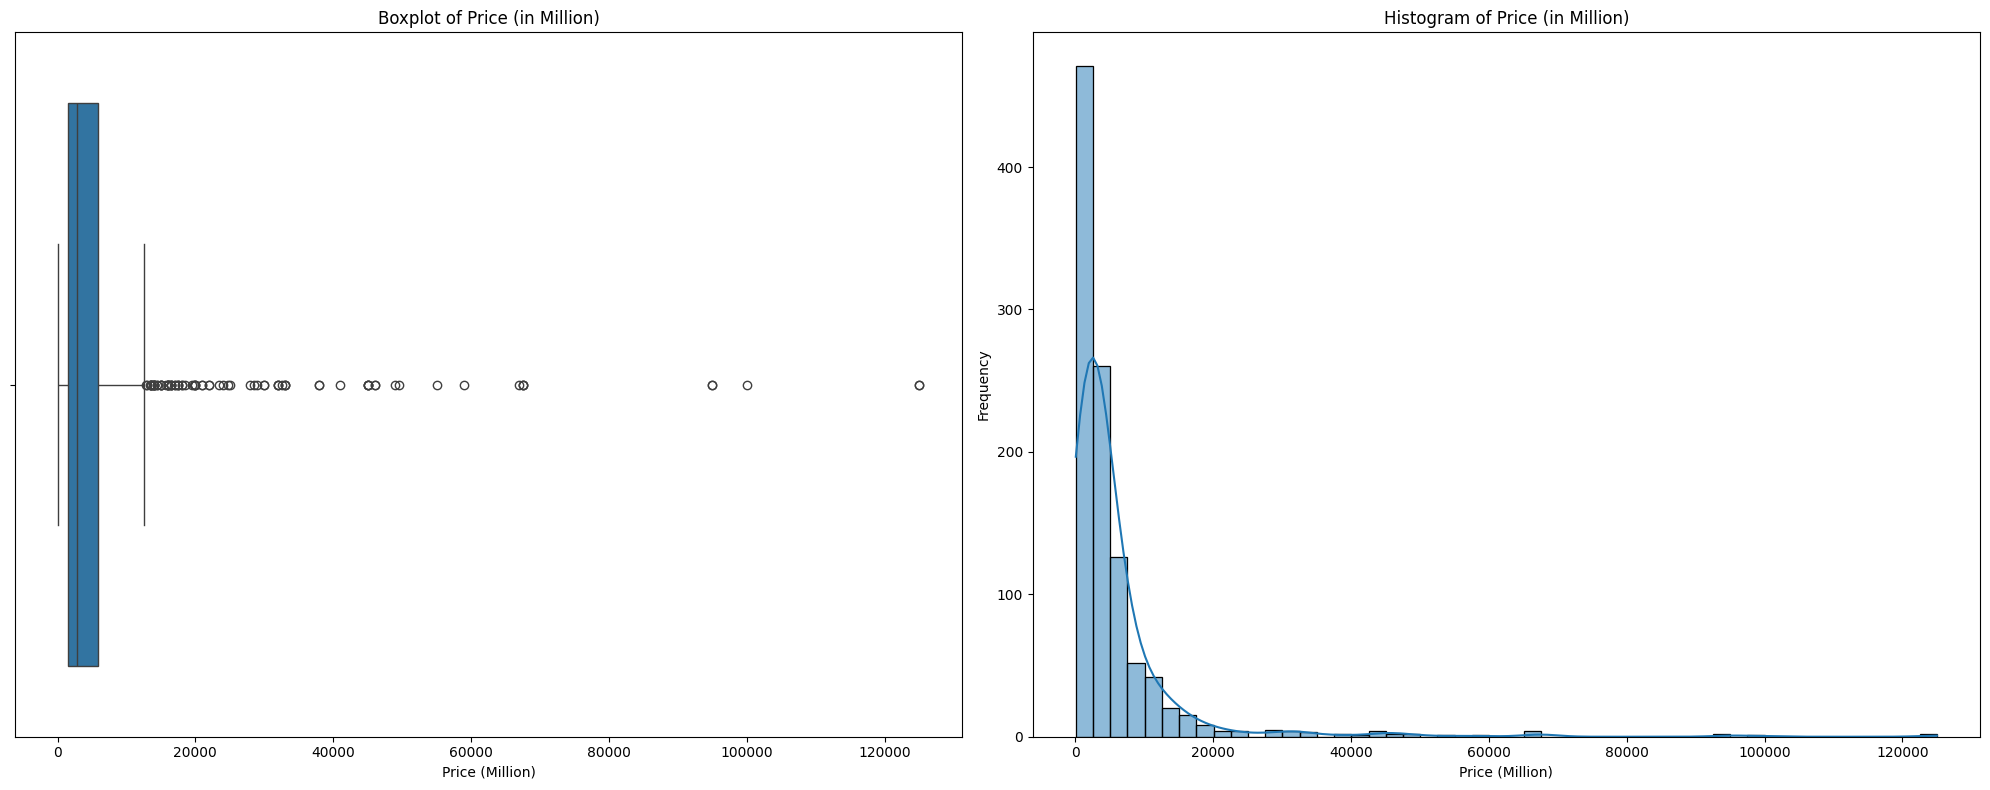

In [124]:
plt.figure(figsize=(20, 8))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_new['price_mio'])
plt.title('Boxplot of Price (in Million)')
plt.xlabel('Price (Million)')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_new['price_mio'], bins=50, kde=True)
plt.title('Histogram of Price (in Million)')
plt.xlabel('Price (Million)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Rumah dengan area Jabodetabek yang dipasarkan di Rumah123.com memiliki rentang harga yang sangat bervariasi dan memilki beberapa outlier yang cenderung memiliki harga tinggi. Outlier ini sengaja tidak dihandle karena merupakan outlier natural yang informasinya perlu dipertahankan. Agar mendapat lebih banyak informasi, analisis dengan distribusi harga normal akan dilakukan. <br>

Merujuk pada hasil cek outlier, angka batas atas yang dapat diterima adalah pada harga Rp18.850.000.000,00. Maka dari itu, tahapan selanjutnya adalah melakukan trimming untuk properti dengan harga di atas batas atas agar dapat melihat distribusi pada nilai yang kecondongannya atau skewnessnya masih bisa diterima.

In [125]:
# Melakukan trimming untuk harga di atas batas atas
df_trim_price_mio = df_new[df_new["price_mio"] < 18850.0]

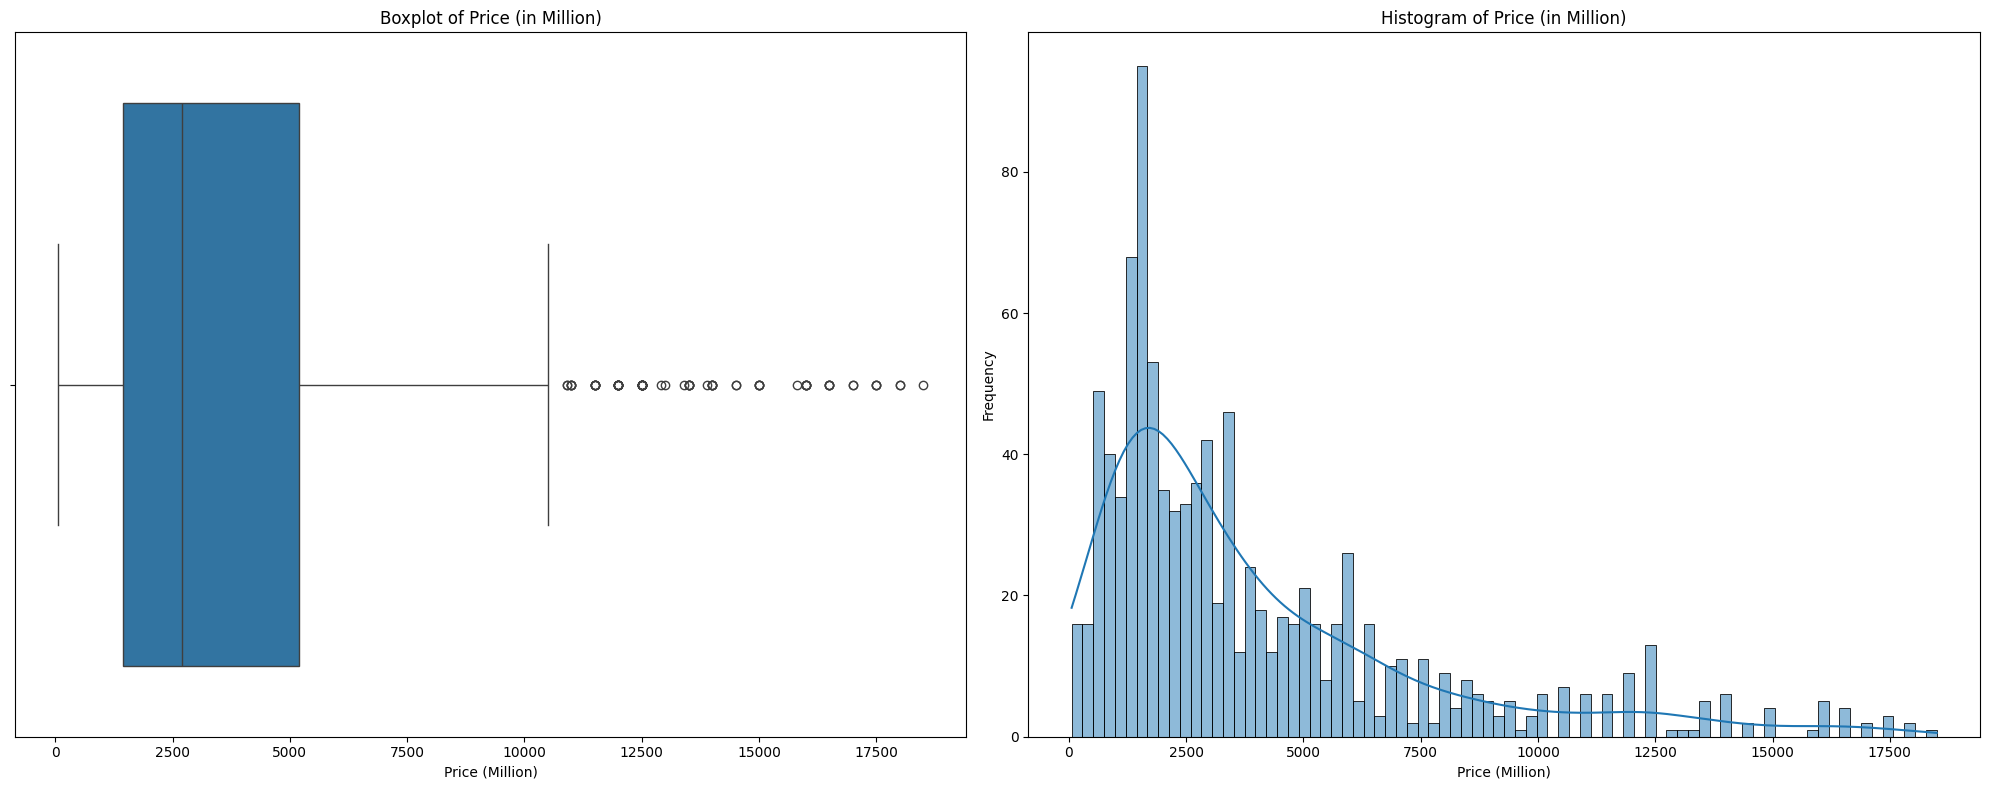

In [126]:
plt.figure(figsize=(20, 8))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_trim_price_mio['price_mio'])
plt.title('Boxplot of Price (in Million)')
plt.xlabel('Price (Million)')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_trim_price_mio['price_mio'], bins=80, kde=True)
plt.title('Histogram of Price (in Million)')
plt.xlabel('Price (Million)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Dari boxplot di atas dapat diketahui bahwa nilai tengah atau median dari harga rumah di Jabodetabek berada di kisaran Rp2.500.000.000,00. pendeknya area di sebelah kiri garis median memberikan informasi bahwa frekuensi harga propertinya berada di sebelah kiri nilai median. Berdasarkan informasi dari histogram, harga jual rumah terbanyak terdapat pada puncak histogram, yakni di sekitaran rentang Rp1.250.000.000,00 - Rp1.500.000,00 <br>

Dapat disimpulkan bahwa: <br>
1. Rumah di Jabodetabek memiliki harga yang sangat bervariasi yang pada bagian selanjutnya akan ditinjau faktor-faktor yang memengaruhinya.
2. Harga tengah dari rumah di Jabodetabek berada di kisaran Rp2.500.000,00.
3. Rentang harga rumah yang paling populer berada pada kisaran Rp1.250.000.000,00 - Rp1.500.000,00. 

# 2. Fitur apa saja yang memiliki korelasi dengan Harga, Luas Tanah, dan Luas Bangunan?

## Uji Korelasi Kolom Numerik

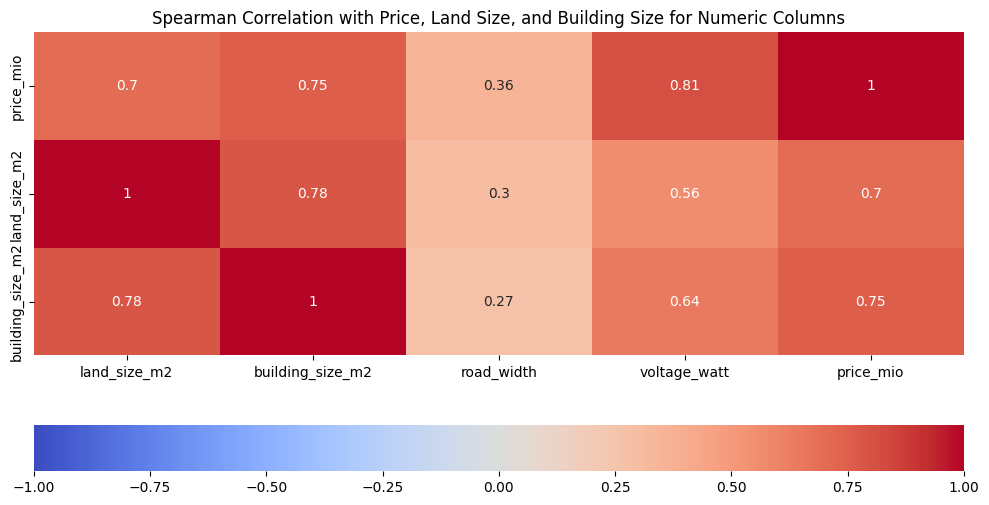

In [127]:
 # Uji korelasi Spearman untuk num_cols terhadap target kolom (price_mio, land_size_m2, building_size_m2)
spearman_corr_price = df_new[num_cols].corr(method='spearman')

# Filter hanya kolom numerik terhadap target (tidak menyertakan target itu sendiri di kolom numerik)
spearman_corr_target = spearman_corr_price.loc[num_cols, ['price_mio', 'land_size_m2', 'building_size_m2']]

# Plot heatmap untuk Spearman correlation
plt.figure(figsize=(12, 6))
sns.heatmap(spearman_corr_target.T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal', 'pad': 0.15})
plt.title('Spearman Correlation with Price, Land Size, and Building Size for Numeric Columns')
plt.show()

**<u>Analisis Korelasi dengan Kolom Numerikal</u>** <br>
Analisis data menunjukkan adanya hubungan yang kuat antara harga properti (price_mio) dengan tegangan listrik (voltage_watt), luas tanah (land_size_m2), dan luas bangunan (building_size_m2). Semakin luas bangunan dan tanah sebuah properti, semakin tinggi pula harganya. Ini berarti, properti dengan lahan yang luas dan bangunan yang besar cenderung memiliki nilai jual yang lebih tinggi. Selain itu, kapasitas listrik juga berkontribusi signifikan terhadap harga. Properti dengan kapasitas listrik yang lebih besar, yang umumnya mengindikasikan adanya fasilitas modern, seperti AC atau peralatan elektronik lainnya, cenderung dibanderol dengan harga yang lebih mahal.

**<u>Implikasi</u>** <br>
Temuan ini memiliki implikasi yang signifikan bagi berbagai pihak di dalam pasar properti: <br>
- **Pembeli**: Pembeli properti umumnya mencari properti dengan ruang yang lebih luas dan fasilitas yang lengkap. Oleh karena itu, mereka bersedia membayar lebih untuk properti yang memenuhi kriteria tersebut.
- **Penjual**: Penjual dapat memaksimalkan nilai jual propertinya dengan cara meningkatkan luas bangunan, menambah fasilitas, atau meningkatkan kapasitas listrik.
- **Pengembang**: Pengembang properti dapat merancang produk yang sesuai dengan preferensi pasar, yaitu properti dengan luas yang cukup dan fasilitas yang modern.
Kesimpulan

Berdasarkan analisis data, dapat disimpulkan bahwa **faktor fisik seperti luas bangunan, luas tanah, dan kapasitas listrik merupakan penentu utama harga properti**. Pembeli sangat menghargai properti yang menawarkan lebih banyak ruang dan fasilitas modern. Oleh karena itu, pengembang perlu memperhatikan faktor-faktor ini dalam merancang dan memasarkan produknya

## Uji Korelasi Kolom Kategorik

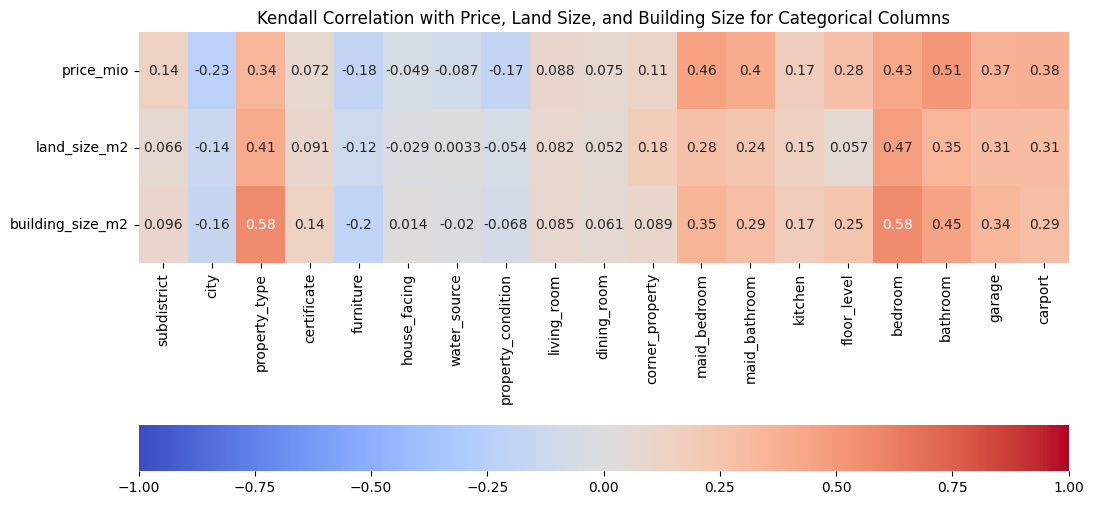

In [128]:
# Uji korelasi Kendall untuk cat_cols terhadap target kolom
kendall_corr_price = df_new[cat_cols + ['price_mio', 'land_size_m2', 'building_size_m2']].apply(
    lambda x: x.astype('category').cat.codes if x.name in cat_cols else x
).corr(method='kendall')
kendall_corr_target = kendall_corr_price[['price_mio', 'land_size_m2', 'building_size_m2']].iloc[:-3]  # Hanya kategorikal terhadap target

# Plot heatmap untuk Kendall correlation
plt.figure(figsize=(12, 6))
sns.heatmap(kendall_corr_target.T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal', 'pad': 0.35})
plt.title('Kendall Correlation with Price, Land Size, and Building Size for Categorical Columns')
plt.yticks(rotation=0)
plt.show()

**<u>Analisis Korelasi Harga Properti dengan Kolom Kategorikal</u>** <br>
Analisis ini menunjukkan hubungan fitur-fitur kategorikal dengan harga properti, luas tanah, dan luas bangunan. Adapun detail yang bisa dihighlight antara lain:
- **Fasilitas Tambahan**: Adanya **fasilitas seperti jumlah kamar tidur, jumlah kamar mandi, kamar tidur pembantu,kamar mandi pembantu, dan carport secara signifikan meningkatkan nilai jual properti**. Ini menunjukkan bahwa pembeli sangat menghargai kenyamanan dan utilitas yang ditawarkan oleh fasilitas-fasilitas tersebut.
- **Tipe Properti**: **Tipe properti tertentu (misalnya, rumah mewah) cenderung memiliki harga yang lebih tinggi**. Ini mengindikasikan bahwa tipe rumah juga merupakan faktor penting yang perlu dipertimbangkan dalam menentukan harga.
- **Kondisi Properti**: **Kondisi properti yang buruk atau kurang terawat dapat menurunkan nilai jual properti secara signifikan**. Pembeli cenderung menghindari properti dengan kondisi yang tidak baik karena membutuhkan biaya perbaikan yang besar.
- **Furnitur**: Kehadiran **furnitur dalam properti tidak selalu berbanding lurus dengan kenaikan harga**. Ini bisa jadi karena preferensi pembeli yang berbeda-beda atau karena kualitas furnitur yang tidak sesuai dengan standar pasar.
- **Lokasi kota**: Hasil analisis menunjukkan bahwa **variabel `city` memiliki korelasi negatif dengan harga**. Ini mungkin disebabkan oleh beberapa faktor yang juga memiliki korelasi negatif dengan kota seperti luas bangunan dan luas tanah.

**<u>Implikasi</u>** <br>
**Bagi Pengembang dan Penjual**:
- Fokus pada fasilitas: Pengembang dan penjual dapat meningkatkan dan mempromosikan nilai jual propertinya dengan menambahkan fasilitas-fasilitas yang dibutuhkan oleh pasar, seperti kamar tambahan, garasi, dan carport.
- Perhatikan kualitas bangunan: Memastikan kualitas bangunan yang baik akan memberikan nilai tambah bagi properti dan meningkatkan harga jual.
- Sesuaikan tipe properti dengan pasar: Mengembangkan tipe properti yang sesuai dengan permintaan pasar akan meningkatkan daya jual.

**Bagi Pembeli**:
- Prioritaskan fasilitas: Pembeli sebaiknya memprioritaskan properti dengan fasilitas yang lengkap dan sesuai dengan kebutuhannya.
Perhatikan kondisi properti: Melakukan inspeksi menyeluruh terhadap kondisi properti sebelum membeli sangat penting untuk menghindari masalah di kemudian hari.
- Bandingkan harga dengan fasilitas: Membandingkan harga properti dengan fasilitas yang ditawarkan akan membantu dalam membuat keputusan pembelian yang tepat.

# 3. Berapa Kecenderungan Harga Jual Rumah di Tiap Kota?

Kecenderungan suatu nilai dapat dicari dengan menggunakan _central tendency_, yaitu mean, median, modus. Pada kasus ini, dataset memiliki harga penjualan properti dengan nilai yang skewness yang tinggi sehingga mean tidak dapat dijadikan opsi karena nilai rata-ratanya dapat terpengaruh dengan nilai outlier. Maka dari itu, data yang digunakan adalah data yang sudah dikecualikan outliernya.

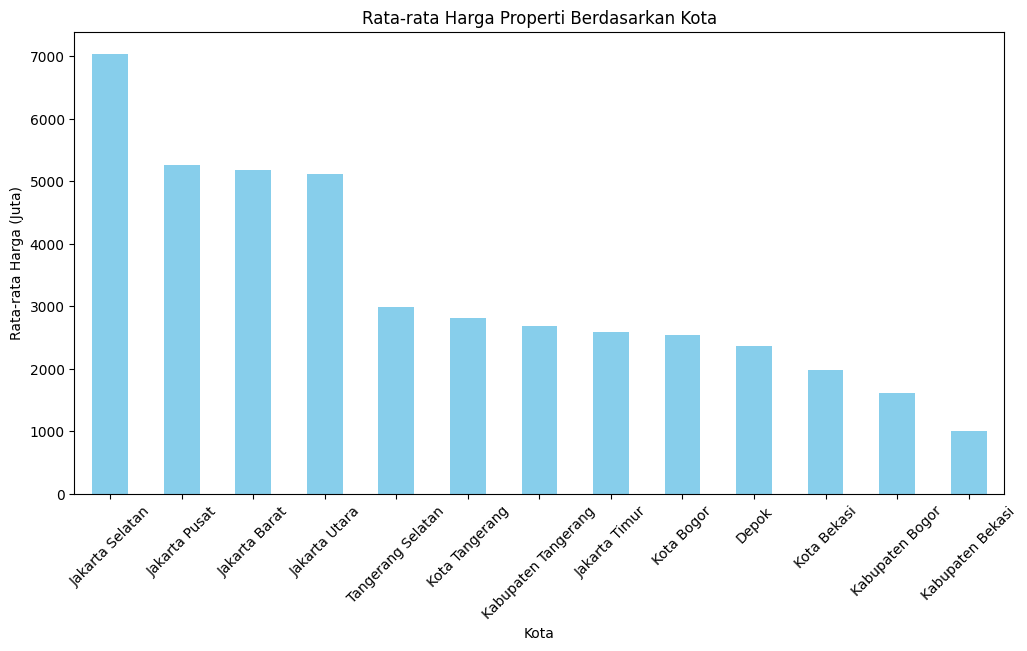

In [129]:
# Rata-rata harga properti berdasarkan kota
avg_price_by_city = df_trim_price_mio.groupby('city')['price_mio'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_price_by_city.plot(kind='bar', color='skyblue')
plt.title('Rata-rata Harga Properti Berdasarkan Kota')
plt.xlabel('Kota')
plt.ylabel('Rata-rata Harga (Juta)')
plt.xticks(rotation=45)
plt.show()

Daerah yang memiliki harga tinggi merupakan daerah strategis yang berada pada pusat kota. Lokasi ini meiliki akses terhadap fasilitas yang lebih beragam dan mobilitas yang lebih mudah sehingga rumah di daerah tersebut memiliki nilai jual yang lebih tinggi.

# 4. Bagaimana Hubungan Luas Tanah dan Kota dengan Harga Properti?

Hubungan antara luas tanah, kota, dan harga properti dapat dilihat menggunakan scatter plot. Tujuan dari analisis ini adalah mengetahui bagaiamna karakteristik luas tanah dan harga properti dari tiap kota.

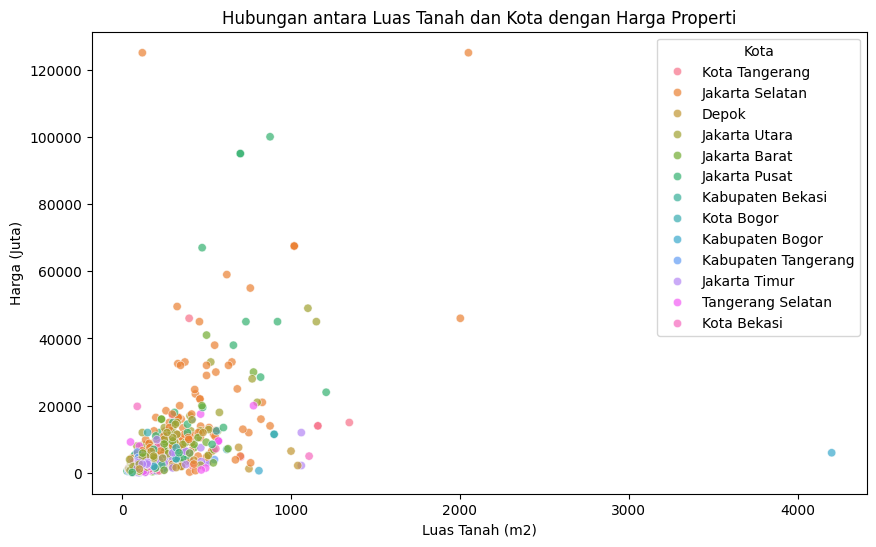

In [130]:
# Hubungan antara luas tanah dan harga properti
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_new, x='land_size_m2', y='price_mio', hue='city', alpha=0.7)
plt.title('Hubungan antara Luas Tanah dan Kota dengan Harga Properti')
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Harga (Juta)')
plt.legend(title='Kota')
plt.show()


Diketahui bahwa dataset ini memiliki outlier yang luas tanahnya yang jauh lebih besar dari data lainnya, namun harga dapat terlihat bahwa harga dari outlier ini tidak mengikuti tren dan cenderung lebih murah. Hal ini kemungkinan dipengaruhi oleh faktor lokasi yang mana kedua outlier ini berada pada daerah Kabupaten Bogor yang mana cukup jauh dari pusat kota. <br>

Untuk menganalisis lebih lanjut, outlier ini perlu dikecualikan terlebih dahulu. Luas tanah yang berada di atas 2.000m2 akan di-trimming pada proses selanjutnya.

In [131]:
df_trim_land_size = df_new[df_new["land_size_m2"] < 2000]

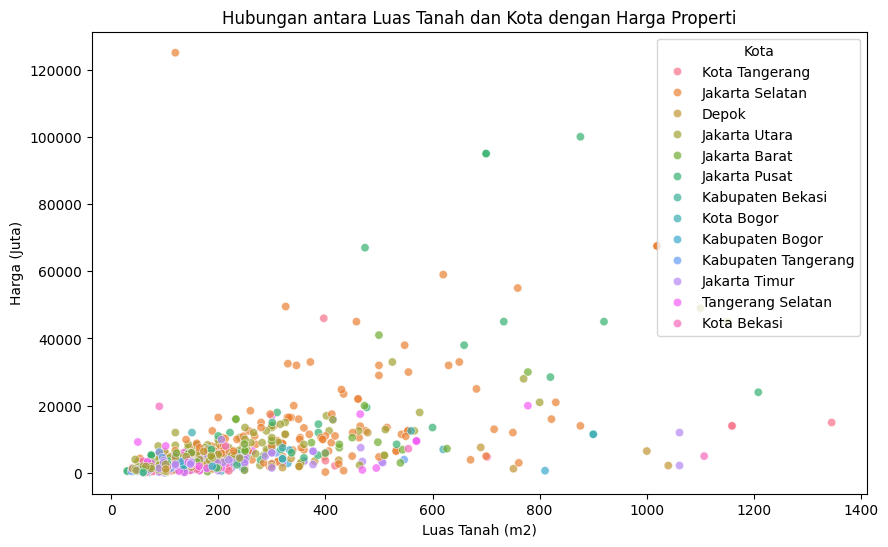

In [132]:
# Hubungan antara luas tanah dan harga properti
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_trim_land_size, x='land_size_m2', y='price_mio', hue='city', alpha=0.7)
plt.title('Hubungan antara Luas Tanah dan Kota dengan Harga Properti')
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Harga (Juta)')
plt.legend(title='Kota')
plt.show()

Analisis terhadap hubungan antara luas tanah, lokasi kota, dan harga properti menunjukkan pola yang cukup menarik. Di kota-kota yang berdekatan dengan pusat kota, terdapat korelasi positif yang kuat antara luas tanah dan harga properti. Semakin luas tanah, semakin tinggi pula nilai propertinya. Fenomena ini mengindikasikan bahwa di area urban dengan aksesibilitas tinggi, faktor luas tanah menjadi pertimbangan utama dalam menentukan harga properti. Sebaliknya, di wilayah perkotaan yang lebih jauh dari pusat kota, kenaikan harga properti tidak sebanding dengan peningkatan luas tanah. Hal ini menandakan bahwa di daerah suburban, faktor lokasi dan fasilitas sekitar mungkin lebih dominan dalam mempengaruhi nilai properti dibandingkan dengan luas tanah semata. <br>

Untuk melihat lebih dalam hubungan lokasi dengan luas tanah dan harga properti, berikut adalah analisis berdasarkan tipe daerah wilayah administrasinya.

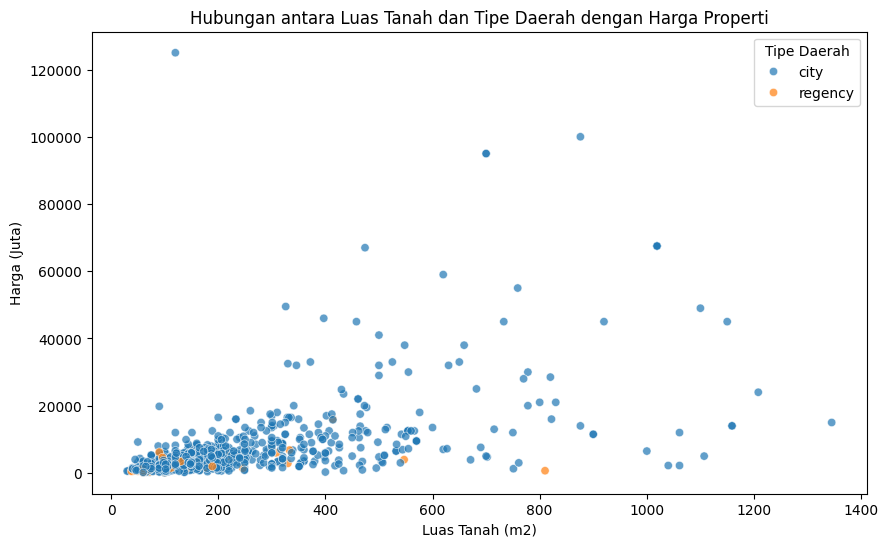

In [133]:
# Hubungan antara luas tanah dan harga properti
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_trim_land_size, x='land_size_m2', y='price_mio', hue='region_type', alpha=0.7)
plt.title('Hubungan antara Luas Tanah dan Tipe Daerah dengan Harga Properti')
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Harga (Juta)')
plt.legend(title='Tipe Daerah')
plt.show()

Grafik di atas memperlihatkan bahwa daerah yang memiliki tipe wilayah administratif kabupaten cenderung memiliki harga yang lebih rendah daripada wilayah perkotaan.

# 5. Bagaimana Hubungan Luas Bangunan dan Kota dengan Harga Properti?

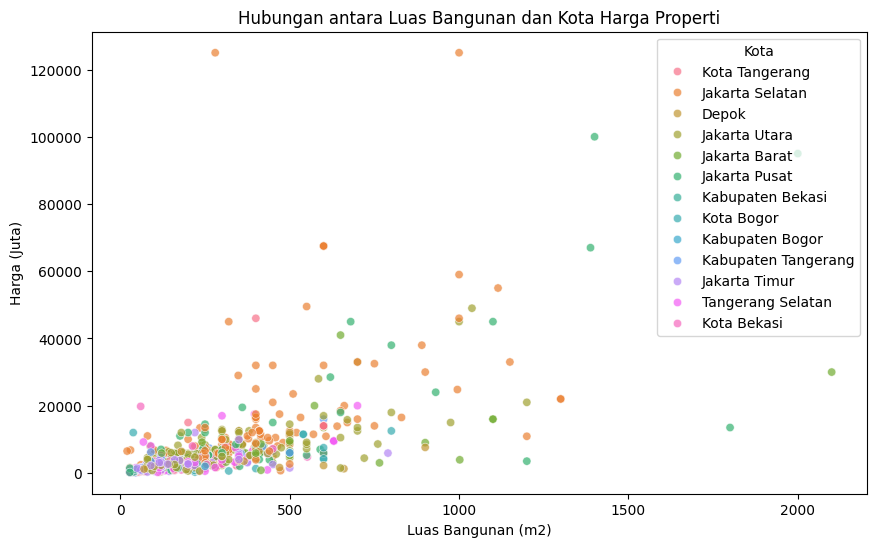

In [134]:
# Hubungan antara luas bangunan dan harga properti
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_new, x='building_size_m2', y='price_mio', hue='city', alpha=0.7)
plt.title('Hubungan antara Luas Bangunan dan Kota Harga Properti')
plt.xlabel('Luas Bangunan (m2)')
plt.ylabel('Harga (Juta)')
plt.legend(title='Kota')
plt.show()


Scatterplot menunjukkan hubungan yang kompleks antara luas bangunan dan harga properti. Meskipun umumnya harga meningkat seiring bertambahnya luas bangunan, namun pengaruh lokasi geografis sangat dominan. Properti di wilayah pusat seperti Jakarta Pusat dan Selatan cenderung memiliki harga yang jauh lebih tinggi dibandingkan wilayah lainnya, bahkan untuk luas bangunan yang sama. Hal ini mengindikasikan bahwa selain ukuran, faktor seperti fasilitas umum, aksesibilitas, dan reputasi daerah juga sangat mempengaruhi nilai properti. Selain itu, adanya outlier dalam data menunjukkan bahwa ada faktor-faktor unik pada properti tertentu yang dapat mempengaruhi harga secara signifikan.<br>

Untuk melihat lebih dalam hubungan lokasi dengan luas bangunan dan harga properti, berikut adalah analisis berdasarkan tipe daerah wilayah administrasinya.

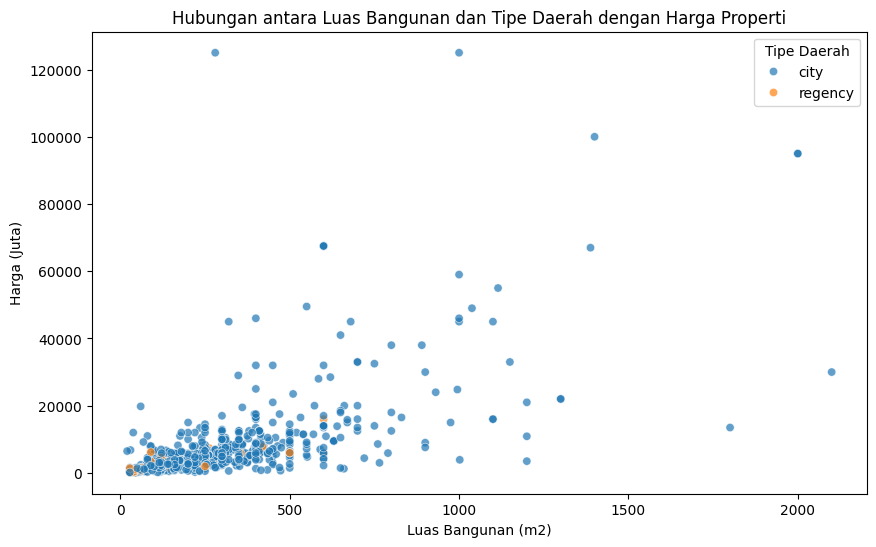

In [135]:
# Hubungan antara luas tanah dan harga properti
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_new, x='building_size_m2', y='price_mio', hue='region_type', alpha=0.7)
plt.title('Hubungan antara Luas Bangunan dan Tipe Daerah dengan Harga Properti')
plt.xlabel('Luas Bangunan (m2)')
plt.ylabel('Harga (Juta)')
plt.legend(title='Tipe Daerah')
plt.show()

Grafik di atas memperlihatkan bahwa daerah yang memiliki tipe wilayah administratif kabupaten cenderung memiliki harga yang lebih rendah daripada yang berada di wilayah perkotaan.

# 6. Apa fasilitas yang Umum Ditemui di Pasar Properti Jabodetabek?

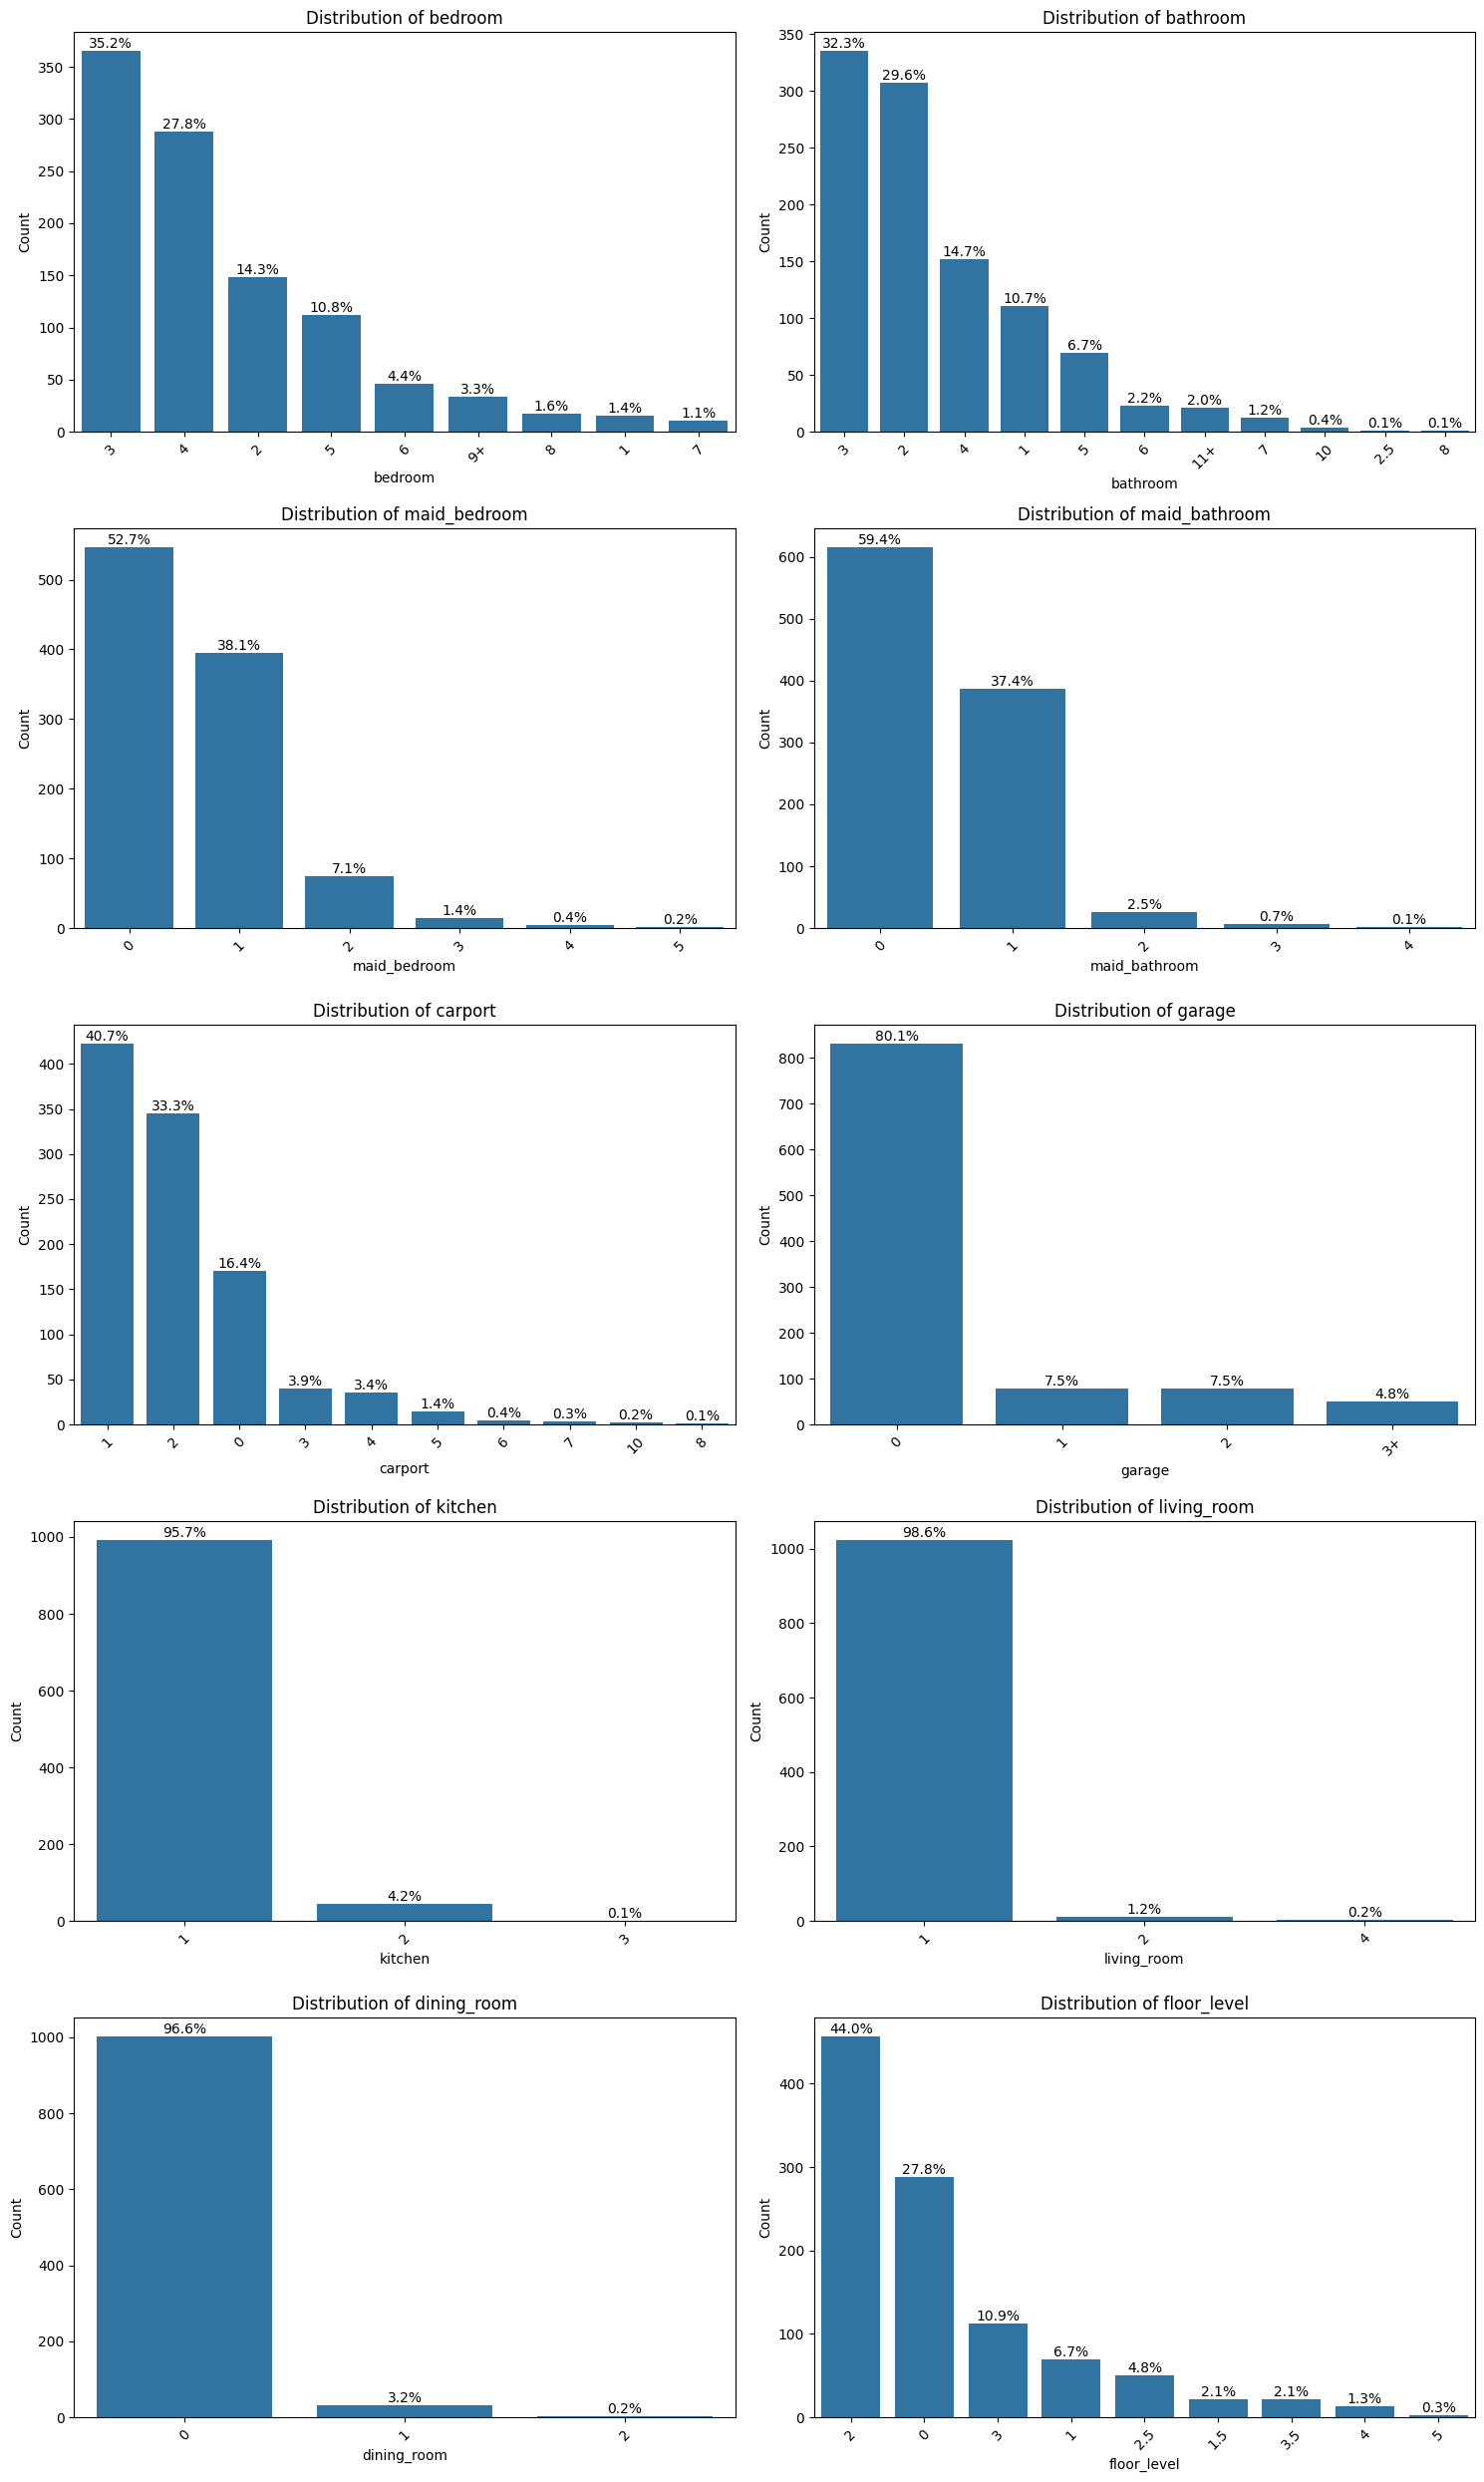

In [136]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

for i, feature in enumerate(house_features):
    ax = sns.countplot(data=df_imputed, x=feature, order=df_imputed[feature].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add percentages on top of each bar
    total = len(df_imputed[feature])
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Remove any empty subplots
for j in range(len(house_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. **Distribusi Kamar Tidur** <br>
- **Interpretasi**: Grafik ini menunjukkan bahwa sebagian besar rumah memiliki 3 kamar tidur. Jumlah rumah dengan 2 dan 4 kamar tidur juga cukup signifikan. Semakin banyak jumlah kamar tidur, semakin sedikit jumlah rumah yang memilikinya. <br>
- **Kesimpulan**: Konfigurasi 3 kamar tidur adalah yang paling umum ditemukan pada rumah-rumah di wilayah yang data ini diambil. <br>

2. **Distribusi Kamar Mandi** <br>
- **Interpretasi**: Sebagian besar rumah memiliki 3 kamar mandi. Jumlah rumah dengan 1 dan 2 kamar mandi juga cukup banyak. Pola penurunan jumlah rumah seiring bertambahnya jumlah kamar mandi mirip dengan grafik kamar tidur. <br>
- **Kesimpulan**: Konfigurasi 3 kamar mandi merupakan yang paling umum ditemukan pada rumah-rumah di wilayah ini. <br>

3. **Distribusi Kamar Tidur Pembantu** <br>
- **Interpretasi**: Mayoritas rumah tidak memiliki kamar tidur pembantu. Hanya sebagian kecil rumah yang memiliki fasilitas ini, dengan jumlah kamar tidur pembantu yang paling umum adalah 1. <br>
- **Kesimpulan**: Fasilitas kamar tidur pembantu tidak terlalu umum ditemukan pada rumah-rumah di wilayah ini. <br>

4. **Distribusi Kamar Mandi Pembantu** <br>
- **Interpretasi**: Sama seperti kamar tidur pembantu, mayoritas rumah juga tidak memiliki kamar mandi pembantu. Jumlah rumah dengan 1 kamar mandi pembantu sangat sedikit. <br>
- **Kesimpulan**: Fasilitas kamar mandi pembantu bahkan lebih jarang ditemukan dibandingkan kamar tidur pembantu. <br>

5. **Distribusi Carport** <br>
- **Interpretasi**: Sebagian besar rumah memiliki 1 carport. Jumlah rumah dengan 2 dan 0 carport juga cukup signifikan.
- **Kesimpulan**: Konfigurasi 1 carport merupakan yang paling umum ditemukan pada rumah-rumah di wilayah ini. <br>

6. **Distribusi Garasi** <br>
- **Interpretasi**: Mayoritas rumah tidak memiliki garasi. Hanya sebagian kecil rumah yang memiliki fasilitas ini, dengan jumlah garasi yang paling umum adalah 1. <br>
- **Kesimpulan**: Fasilitas garasi tidak terlalu umum ditemukan pada rumah-rumah di wilayah ini. <br>

7. **Distribusi Dapur** <br>
- **Interpretasi**: Hampir semua rumah memiliki 1 dapur. Hanya ada sedikit sekali rumah yang memiliki lebih dari 1 dapur.<br>
- **Kesimpulan**: Hampir semua rumah di wilayah ini memiliki 1 dapur. <br>

8. **Distribusi Ruang Tamu** <br>
- **Interpretasi**: Hampir semua rumah memiliki 1 ruang tamu. Sama seperti dapur, hanya ada sedikit sekali rumah yang memiliki lebih dari 1 ruang tamu. <br>
- **Kesimpulan**: Hampir semua rumah di wilayah ini memiliki 1 ruang tamu. <br>

9. **Distribusi Ruang Makan** <br>
- **Interpretasi**: Mayoritas rumah tidak memiliki ruang makan. Hanya sebagian kecil rumah yang memiliki fasilitas ini, dengan jumlah ruang makan yang paling umum adalah 1. <br>
- **Kesimpulan**: Fasilitas ruang makan tidak terlalu umum ditemukan pada rumah-rumah di wilayah ini. <br>


Berdasarkan grafik-grafik di atas, dapat disimpulkan bahwa: <br>
- **Konfigurasi standar**: Kebanyakan rumah di wilayah ini memiliki konfigurasi standar dengan 3 kamar tidur, 2 kamar mandi, 1 carport, 1 dapur, dan 1 ruang tamu. <br>
- **Fasilitas tambahan**: Fasilitas tambahan seperti kamar tidur pembantu, kamar mandi pembantu, ruang makan, dan garasi tidak terlalu umum ditemukan. <br>
- **Variasi terbatas**: Variasi jumlah ruangan selain kamar tidur dan kamar mandi cenderung sangat kecil, hampir semua rumah memiliki 1 dapur, ruang tamu, dan ruang makan.



# 7. Berapa Kecenderungan Harga Jual Rumah berdasarkan Tipe Propertinya?

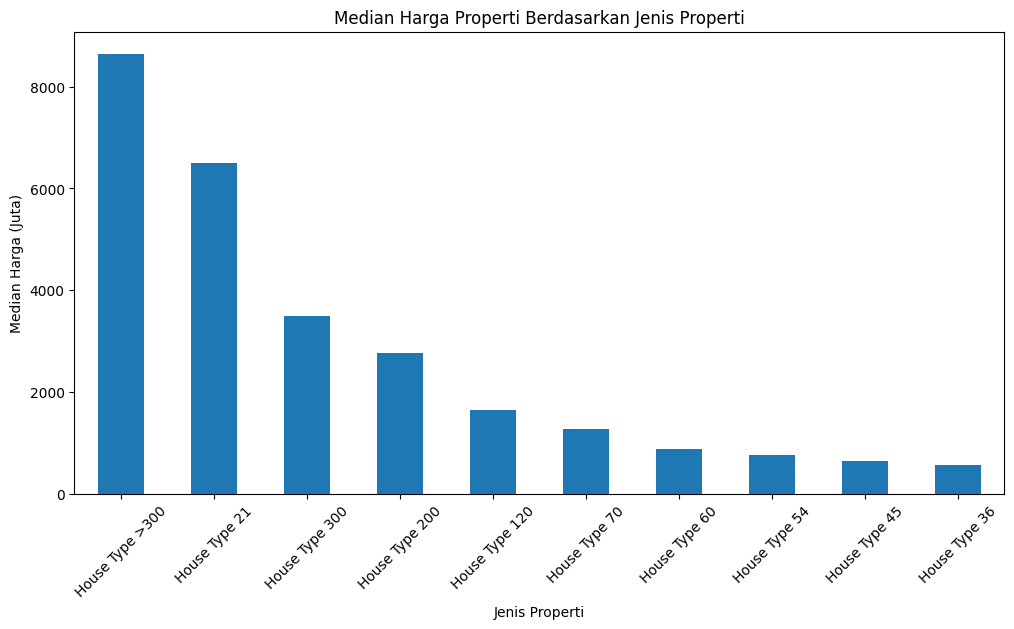

In [137]:
# Median harga properti berdasarkan jenis properti
median_price_by_type = df_new.groupby('property_type')['price_mio'].median().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
median_price_by_type.plot(kind='bar')
plt.title('Median Harga Properti Berdasarkan Jenis Properti')
plt.xlabel('Jenis Properti')
plt.ylabel('Median Harga (Juta)')
plt.xticks(rotation=45)
plt.show()

Hasil analisis menunjukkan adanya anomali pada hubungan antara ukuran rumah dan harga jual. Menariknya, rumah tipe 21 justru memiliki nilai jual median yang lebih tinggi dibandingkan dengan tipe rumah yang lebih besar. Fenomena ini mengindikasikan bahwa faktor lain di luar tipe properti, seperti lokasi, fasilitas sekitar, atau bahkan persepsi pasar terhadap tipe rumah tertentu, memiliki pengaruh yang lebih dominan dalam menentukan harga properti.

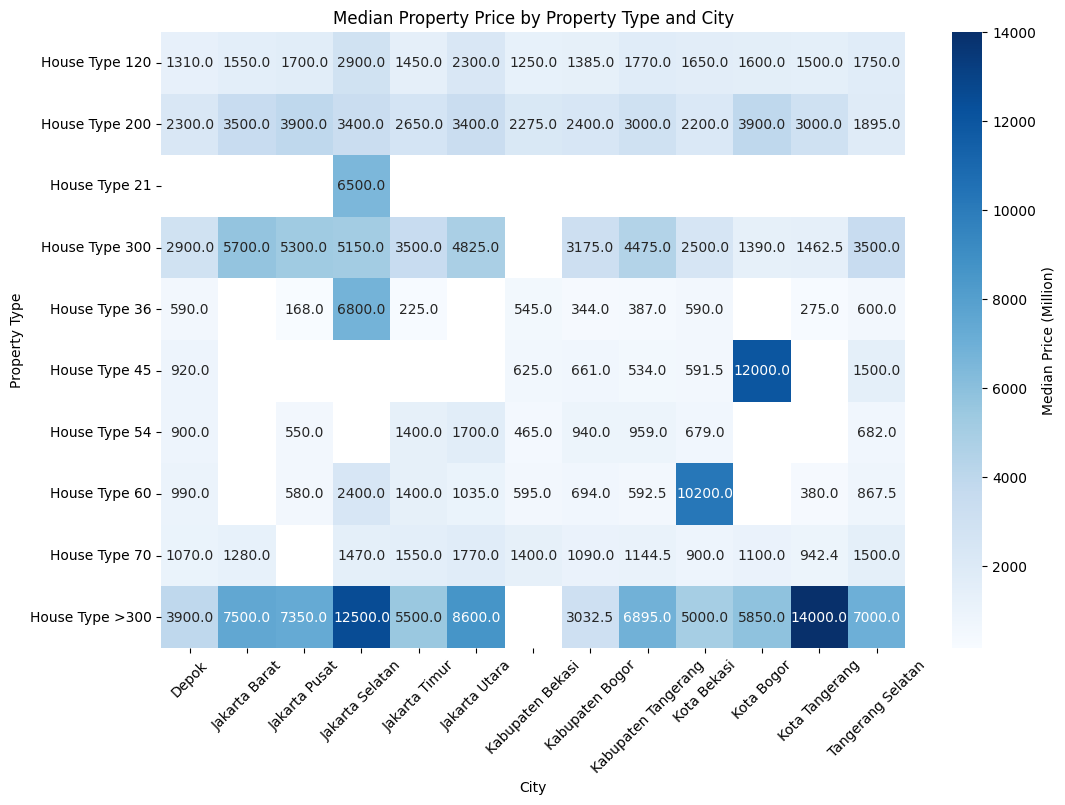

In [138]:
# Hitung harga median properti untuk setiap kombinasi jenis properti dan kota
median_price = df_new.groupby(['property_type', 'city'])['price_mio'].median().unstack()

# Buat heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(median_price, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Median Price (Million)'})
plt.title('Median Property Price by Property Type and City')
plt.xlabel('City')
plt.ylabel('Property Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Rumah 21 ternyata hanya terdapat di daerah Jakarta Selatan yang mana daerah ini merupakan lokasi yang strategis sehingga properti tersebut dibandrol dengan harga tinggi.

# Pengambilan Kesimpulan

## Recap
1. Harga rumah di Jabodetabek sangat bervariasi, dengan harga tengah berada di kisaran Rp2.500.000,00. Rentang harga yang paling populer di sekitaran Rp1.250.000.000,00 - Rp1.500.000.000,00. <br>
2. Faktor fisik seperti luas bangunan, luas tanah, kapasitas listrik, jumlah kamar tidur, jumlah kamar mandi, kamar tidur pembantu, kamar mandi pembantu, carport, tipe properti, konsidi properti, furniture, dan lokasi kota memiliki korelasi yang signifikan dalam penentuan harga properti. <br>
3. Jakarta Selatan memiliki harga penjualan properti paling tinggi. Wilayah dengan harga rumah tinggi umumnya berada di area strategis di pusat kota. Lokasi ini memiliki akses yang luas ke beragam fasilitas dan kemudahan transportasi, sehingga nilai jual rumah di sana cenderung lebih mahal. <br>
4. Pada lokasi yang berada dekat pusat kota, luas tanah memiliki korelasi positif kuat dengan harga, menandakan faktor utama dalam menentukan nilai. Namun, di area suburban, kenaikan harga tidak selalu sebanding dengan luas tanah, karena lokasi dan fasilitas sekitar lebih memengaruhi nilai properti. <br>
5. Meskipun secara umum harga properti meningkat seiring bertambahnya luas bangunan, wilayah-wilayah tertentu seperti pusat kota cenderung memiliki harga yang lebih tinggi, bahkan untuk bangunan dengan ukuran yang sama. Ini menunjukkan bahwa faktor lain seperti fasilitas umum, reputasi daerah, dan aksesibilitas juga berperan penting dalam menentukan nilai properti. <br>
6. Mayoritas rumah di wilayah ini memiliki 3 kamar tidur dan 3 kamar mandi. Fasilitas tambahan seperti kamar pembantu atau garasi tidak terlalu banyak ditemukan. Variasi jumlah ruangan lain seperti dapur, ruang tamu, dan ruang makan juga cenderung terbatas, menunjukkan pola desain rumah yang cukup standar di wilayah tersebut. <br>
7. Tipe properti memiliki hubungan yang cukup signifikan dengan harga yang ditawarkan. Semakin besar tipe rumahnya, maka harganya juga akan semakil mahal. Namun, selain tipe properti, banyak faktor lain yang juga perlu dipertimbangkan.<br>

## Kesimpulan <br>
Berdasarkan analisis pasar properti di Jabodetabek, terlihat bahwa penentuan harga rumah merupakan hasil interaksi kompleks dari berbagai faktor, dengan lokasi dan karakteristik fisik properti sebagai penentu utama. Meskipun harga tengah berada di kisaran Rp2.500.000,00, terdapat variasi signifikan yang dipengaruhi terutama oleh kedekatan dengan pusat kota dan akses ke fasilitas umum. Properti di area strategis pusat kota menunjukkan korelasi kuat antara luas tanah dan harga, sementara di area suburban, faktor lokasi dan fasilitas sekitar lebih dominan dalam menentukan nilai. Tren desain rumah cenderung seragam dengan dominasi 3 kamar tidur dan 3 kamar mandi, menunjukkan preferensi pasar yang konsisten, sedangkan tipe properti yang lebih besar umumnya berkorelasi dengan harga yang lebih tinggi, meskipun tetap dipengaruhi oleh faktor-faktor lain seperti lokasi dan kelengkapan fasilitas. <br>

## Business Recommendation
Berdasarkan analisis data properti di Jabodetabek, berikut beberapa rekomendasi bisnis strategis: <br>

1. **Pengembangan Properti Tipe Menengah** <br>
Fokus pada pembangunan rumah dengan 3 kamar tidur dan 3 kamar mandi, yang merupakan konfigurasi paling diminati
Target harga di kisaran Rp1.250.000.000,00 - Rp1.500.000.000,00 untuk memenuhi segmen pasar terbesar
Prioritaskan desain yang efisien namun tetap memenuhi standar kenyamanan modern <br>


2. **Strategi Lokasi dan Pengembangan** <br>
Identifikasi area suburban yang memiliki potensi berkembang, terutama yang akan mendapatkan akses transportasi atau fasilitas publik baru
Investasi di lokasi yang memiliki rencana pengembangan infrastruktur untuk mengantisipasi kenaikan nilai properti
Pertimbangkan pengembangan mixed-use property di area strategis untuk memaksimalkan nilai lahan. <br>


3. **Diferensiasi Produk** <br>
Tambahkan fitur yang membedakan dari kompetitor, seperti smart home system atau desain ramah lingkungan
Kembangkan konsep cluster dengan fasilitas komunal yang menarik
Tawarkan opsi customization untuk interior dan layout sesuai kebutuhan pembeli. <br>

## Further Improvement <br>
1. **Menambahkan Informasi Baru dan Analisis Korelasi** <br>
Memasukkan variabel-variabel seperti nama developer, sistem KPR, fitur smart home, dan aksesibilitas ke fasilitas umum. Dengan demikian, dapat melihat korelasi yang lebih kompleks antara berbagai faktor tersebut dengan harga properti. Misalnya, kita dapat menganalisis apakah properti dari developer terkenal dengan reputasi baik selalu memiliki harga yang lebih tinggi, atau apakah keberadaan fitur smart home secara signifikan meningkatkan nilai jual sebuah rumah. <br>

2. **Memperluas Area Analisis** <br>
Agar mendapatkan gambaran yang lebih komprehensif, analisis tidak hanya terbatas pada Jabodetabek. Kita dapat memperluas cakupan analisis ke kota-kota besar lainnya di Indonesia seperti Surabaya, Bandung, atau Medan. Dengan membandingkan harga properti di berbagai kota, kita dapat melihat tren pasar yang lebih luas dan mengidentifikasi faktor-faktor regional yang mempengaruhi harga properti. <br>

3. **Memperluas Sumber Data** <br>
Untuk meningkatkan akurasi dan kelengkapan data, kita perlu memanfaatkan berbagai sumber data selain portal properti seperti Rumah.com. Dengan menggabungkan data dari berbagai sumber, dataset yang lebih kaya akan informasi sehingga analisis yang dilakukan dapat lebih mendalam.